<a href="https://colab.research.google.com/github/aimlbits16/Project/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.1	Problem definition:

Predict denials of denial claims from history data

In [0]:
# Google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


2.2	History Data Set 
Data in excel contains three tabs

	Tab-1 contains all attributes of the claims processed except Label   
	Tab-2 contains only Target variable (Label) of each row of Tab-1 data with one common attribute  
	Tab-3 contains all attribute list 

2.3 Data Pre-processing 

1.Read Tab1- data set and Tab-2 Data set and create two panda data frames

2.Merge two data frames into one to place Label properly against each row.

3.Attributes of Tab-1 and Tab-2 are shown below

In [2]:
# Library Imports

import sys
print('python:{}'.format(sys.version))
import scipy as sp
print('scipy:{}'.format(sp.__version__))
import numpy as np
print('numpy:{}'.format(np.__version__))
import pandas as pd
print('pandas:{}'.format(pd.__version__))
import math

from sklearn.preprocessing import LabelEncoder, StandardScaler
#import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve,f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from collections import Counter

python:3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
scipy:1.4.1
numpy:1.18.3
pandas:1.0.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Define Functions

In [0]:
#% of missing values in each column:
def find_missing_values_func(df):    # Input parameter is dataframe        
    mis_val = df.isnull().sum()        
    mis_val_percent = 100 * df.isnull().sum() / len(df)        
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
    mis_val_table_ren_columns = mis_val_table.rename(        
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
    mis_val_table_ren_columns = mis_val_table_ren_columns[            
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(        
        '% of Total Values', ascending=False).round(1)        
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"               
           "There are " + str(mis_val_table_ren_columns.shape[0]) +              
           " columns that have missing values.")        
    return mis_val_table_ren_columns

def drop_missing_values(df, percentage):
    columns = df.columns
    percent_missing = df.isnull().sum()*100/len(df)
    missing_value_df = pd.DataFrame({'column_name': columns, 'percent_missing':percent_missing})
    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    df = df.drop(missing_drop, axis=1)
    return df

In [0]:
InputFolder = '/content/gdrive/My Drive/capstone-project/input_data'
OutFolder = '/content/gdrive/My Drive/capstone-project/output_data'
inFile = InputFolder + '/ZCUPClaimDNA-History-Data-v2.xlsx'


In [5]:
# Data Reads - All required data is in data folders
df_history_dataset = pd.read_excel(inFile, 
                                   sheet_name='HistoryData',
                                   header=0,
                                   converters={'srlno':np.int64, 
                                               'Claim.Number':str,
                                               'Claim.Line.Number':str,
                                               'Member.ID':str,
                                               'Provider.ID':str,
                                               'Revenue.Code':str,
                                               'Service.Code':str,
                                               'Place.Of.Service.Code':str,
                                               'Procedure.Code':str,
                                               'Diagnosis.Code':str,
                                               'Claim.Charge.Amount':np.float64,
                                               'Denial.Reason.Code':str,
                                               'In.Out.Of.Network':str,
                                               'Subscriber.Payment.Amount':np.float64,
                                               'Provider.Payment.Amount':np.float64,
                                               'Claim.Type':str,
                                               'Claim.Subscriber.Type':str,
                                               'Claim.Current.Status':str,
                                               'Network.ID':str,
                                               'Agreement.ID':str
                                              }, skipinitialspace=True)
df_labels_dataset = pd.read_excel(inFile, 
                                  sheet_name='Accept-Denial-Label', 
                                  header=0,
                                  converters={'srlno':np.int64, 
                                              'Label':np.int64
                                             }, skipinitialspace=True)

df_data = pd.merge(df_history_dataset, df_labels_dataset, on='Srlno')
df_data.columns = df_data.columns.str.strip()

df_data_raw = df_data.copy()

print(df_history_dataset.head())
print(df_labels_dataset.head())

print(df_history_dataset.describe())
print(df_labels_dataset.describe())

print(df_data.head())
print(df_data.describe())

   Srlno Claim.Number  ...    Network.ID  Agreement.ID
0      1     28849991  ...  P00000000002  FH001310QB01
1      2     81404290  ...  P00000000007  FH002451QPD1
2      3     81404290  ...  P00000000007  FH002451QPD1
3      4     81404290  ...  P00000000007  FH002451QPD1
4      5     81404290  ...  P00000000007  FH002451QPD1

[5 rows x 20 columns]
   Srlno  Label
0      1      0
1      2      0
2      3      0
3      4      0
4      5      0
               Srlno  ...  Provider.Payment.Amount
count  472559.000000  ...            472559.000000
mean   236280.000000  ...               299.664982
std    136416.177266  ...              2651.754222
min         1.000000  ...                 0.000000
25%    118140.500000  ...                 0.000000
50%    236280.000000  ...                 0.000000
75%    354419.500000  ...                 0.000000
max    472559.000000  ...            491735.224680

[8 rows x 4 columns]
               Srlno          Label
count  472559.000000  472559.00000

In [6]:
df_data = df_data_raw.copy()
print(df_data.shape)
dataTypeSeries = df_data.dtypes
print(dataTypeSeries)

(472559, 21)
Srlno                          int64
Claim.Number                  object
Claim.Line.Number             object
Member.ID                     object
Provider.ID                   object
Revenue.Code                  object
Service.Code                  object
Place.Of.Service.Code         object
Procedure.Code                object
Diagnosis.Code                object
Claim.Charge.Amount          float64
Denial.Reason.Code            object
In.Out.Of.Network             object
Subscriber.Payment.Amount    float64
Provider.Payment.Amount      float64
Claim.Type                    object
Claim.Subscriber.Type         object
Claim.Current.Status          object
Network.ID                    object
Agreement.ID                  object
Label                          int64
dtype: object


2.4 Find Shape and data type 

In [7]:
print(df_data.shape)
# To be Categorized as per data provided
df_data.loc[df_data['Revenue.Code'].isin([' ']), 'Revenue.Code'] = 'OTHERS'
df_data.loc[df_data['Service.Code'].isin([' ']), 'Service.Code'] = 'OTHERS'
df_data.loc[df_data['Diagnosis.Code'].isin([' ']), 'Diagnosis.Code'] = 'OTHERS'

# To be Label Catgeorized
df_data.loc[df_data['Procedure.Code'].isin([' ']), 'Procedure.Code'] = 'OTHERS'
df_data.loc[df_data['In.Out.Of.Network'].isin([' ']), 'In.Out.Of.Network'] = 'OTHERS'
df_data.loc[df_data['Claim.Type'].isin([' ']), 'Claim.Type'] = 'OTHERS'
df_data.loc[df_data['Claim.Subscriber.Type'].isin([' ']), 'Claim.Subscriber.Type'] = 'OTHERS'
df_data.loc[df_data['Claim.Current.Status'].isin([' ']), 'Claim.Current.Status'] = 'OTHERS'


# To Be Dropped
df_data.loc[df_data['Member.ID'].isin([' ']), 'Member.ID'] = None
df_data.loc[df_data['Network.ID'].isin([' ']), 'Network.ID'] = None
df_data.loc[df_data['Agreement.ID'].isin([' ']), 'Agreement.ID'] = None
df_data.loc[df_data['Provider.ID'].isin([' ']), 'Provider.ID'] = None

df_data.loc[df_data['Place.Of.Service.Code'].isin([' ']), 'Place.Of.Service.Code'] = None
df_data.loc[df_data['Claim.Number'].isin([' ']), 'Claim.Number'] = None
df_data.loc[df_data['Claim.Line.Number'].isin([' ']), 'Claim.Line.Number'] = None

df_data.loc[df_data['Subscriber.Payment.Amount'].isin([' ']), 'Subscriber.Payment.Amount'] = np.nan

# To be cleaned according to data provided and then used to enrich Label - Any accepted claim should not have a denial reason code
df_data.loc[df_data['Denial.Reason.Code'].isin([' ']), 'Denial.Reason.Code'] = ' '


# To Be Scaled
df_data.loc[df_data['Claim.Charge.Amount'].isin([' ']), 'Claim.Charge.Amount'] = np.nan
df_data.loc[df_data['Provider.Payment.Amount'].isin([' ']), 'Provider.Payment.Amount'] = np.nan

print(df_data['Denial.Reason.Code'].value_counts())

columnsWiseMissingValue = find_missing_values_func(df_data)
print(columnsWiseMissingValue)

(472559, 21)
       326030
PDC     52737
K62     34006
J2M      7088
J72      5135
        ...  
KIQ         1
J01         1
JB2         1
JMY         1
KEK         1
Name: Denial.Reason.Code, Length: 259, dtype: int64
Your selected dataframe has 21 columns.
There are 4 columns that have missing values.
                       Missing Values  % of Total Values
Place.Of.Service.Code          472156               99.9
Network.ID                     206585               43.7
Agreement.ID                   204256               43.2
Claim.Number                   174023               36.8


2.5	Target Value (Label) setting and cleaning

2.5.1    We will consider following valid Denial.Reason.Code F13, J8G, JO5, JB8, JE1, JC9, JF1, JF9, JG1, JPA and JES
The goal is to develop predictive model to predict claims that would be denied with the above Denial.Reason.Code only. Any row with non-valid Denial.Reason.Code will be considered as garbage that need to be deleted

Rows with label zero (0) without any Denial.Reason.Code (blank)  should be kept

In [8]:
  print(df_data.groupby('Denial.Reason.Code')['Denial.Reason.Code'].count())

  validReasonCodes = ['F13', 'J8G', 'JO5', 'JB8', 'JE1', 'JC9', 'JF1', 'JF9', 'JG1', 'JPA', 'JES', ' '] 
  # added a ' ' since there are valid rows with a space in data cells for Denial Reason Code for claims that are approved
  df_data=df_data[(df_data['Denial.Reason.Code'].isin(validReasonCodes))]

  print(df_data.groupby('Denial.Reason.Code')['Denial.Reason.Code'].count())



Denial.Reason.Code
       326030
104        44
17          3
18          1
19        242
        ...  
TF1      1031
TR2        22
UM0         2
UM1        28
UM2         7
Name: Denial.Reason.Code, Length: 259, dtype: int64
Denial.Reason.Code
       326030
F13      1068
J8G       382
JB8       128
JC9        49
JE1        33
JES        50
JF1         4
JF9        98
JG1        10
JO5       105
JPA        44
Name: Denial.Reason.Code, dtype: int64


2.5.2   Check distribution of Label in terms of percentage 0/1

In [9]:
print(df_data.shape)
print(df_data['Label'].value_counts())

(328001, 21)
0    326030
1      1971
Name: Label, dtype: int64


In [10]:
distLabels = (df_data['Label'].value_counts()/ df_data['Label'].count())*100
print('Distribution:\n{}'.format(distLabels))

Distribution:
0    99.399087
1     0.600913
Name: Label, dtype: float64


2.5.3   Find number of  distinct valid Denial.Reason.Code

In [11]:
print(df_data['Denial.Reason.Code'].unique())

[' ' 'JB8' 'J8G' 'F13' 'JF1' 'JE1' 'JES' 'JO5' 'JG1' 'JPA' 'JC9' 'JF9']


2.6	Handling Predictor Variables
Predictors variables ( All input variables except Target variable)  that are used to predict the 'Target Variable'.


2.6.1  Identify

•	continuous numeric value
•	tag/code value
•	Other columns ID type.

In [12]:
df_data.dtypes

Srlno                          int64
Claim.Number                  object
Claim.Line.Number             object
Member.ID                     object
Provider.ID                   object
Revenue.Code                  object
Service.Code                  object
Place.Of.Service.Code         object
Procedure.Code                object
Diagnosis.Code                object
Claim.Charge.Amount          float64
Denial.Reason.Code            object
In.Out.Of.Network             object
Subscriber.Payment.Amount    float64
Provider.Payment.Amount      float64
Claim.Type                    object
Claim.Subscriber.Type         object
Claim.Current.Status          object
Network.ID                    object
Agreement.ID                  object
Label                          int64
dtype: object

2.6.2  Find uniue combinations for revenue code, service code and diagnosis code

In [13]:
print(df_data['Revenue.Code'].unique())
print(df_data['Service.Code'].unique())
print(df_data['Diagnosis.Code'].unique())

['128' '24' '250' '258' '271' '300' '301' '305' '306' '307' '309' '420'
 '424' '430' '434' '440' '444' '636' '351' '324' '352' '410' '730' '361'
 '302' '320' '350' '390' '274' '370' '921' '450' '915' '912' '126' '124'
 '914' '771' '483' '913' '740' '121' '402' '905' '341' '343' '482' '762'
 '949' '431' '421' '761' '359' '333' '943' '441' '433' '272' '490' '710'
 '278' '259' '750' '312' '510' '360' '637' '329' '206' '200' '460' '481'
 '270' '275' '480' '276' '611' '310' '314' '261' '369' '920' '940' '941'
 '911' '919' '917' '111' '260' '403' '279' '391' '918' '801' '999' '311'
 '610' '612' '401' '323' '344' '731' '981' '412' '812' '127' '322' '819'
 '404' '829' '131' '633' '615' '335' '614' 'OTHERS' '922' '822' '400'
 '732' '25' '929' '948' '942' '622' '616' '342' '129' '635' '634' '118'
 '331' '443' '255' '136' '134' '254' '117' '249' '100' '122' '171' '720'
 '210' '723' '821' '722' '471' '112' '172' '900' '916' '123' '120' '618'
 '174' '205' '790' 'XXXX' '173' '831' '901' '413' '832' 

2.6.3  Handling Categorical Values

In [14]:
#2.6.3.1 Clubbing of Category Value (1 ,2,3 – High , Medium , Low possibility group respectively)

# Revenue Code
High_Revenue_Code = ["810", "811", "124", "261", "260", "331", "914", "174", "634", "173", "682", "126", "128", "172", "127", "200", "821", "134", "302", "740", "249", "270", "771", "361", "310", "434"]
Medium_Revenue_Code= ["210", "275", "122", "610", "206", "258", "444", "278", "117", "259", "121", "112", "276", "731", "750", "460", "360", "271", "730", "307", "424", "370", "250", "410", "940", "305", "350", "921", "480", "111", "351", "920", "636", "309", "300", "390", "301", "450", "440", "306", "311", "324", "710", "341", "272", "343", "942", "171", "482", "420", "490", "483", "312", "481", "352", "510", "402", "320", "720", "762", "761", "430", "403"]

df_data.loc[df_data['Revenue.Code'].isin(High_Revenue_Code), 'Revenue.Code.Group'] = 1
df_data.loc[df_data['Revenue.Code'].isin(Medium_Revenue_Code), 'Revenue.Code.Group' ] = 2
df_data.loc[~df_data['Revenue.Code'].isin(High_Revenue_Code + Medium_Revenue_Code), 'Revenue.Code.Group'] = 3
print(df_data['Revenue.Code.Group'].value_counts())

2.0    281326
3.0     30655
1.0     16020
Name: Revenue.Code.Group, dtype: int64


In [15]:
# Service Code
High_Service_Code = ["UNI", "RL8Y", "RM8W", "DU7O", "IH7O", "RM8I", "RI7Y", "SB7W", "GB7A", "NI7I", "OVV", "RM9I", "RR8I", "IMY", "RT8I", "RY8W", "RY7I", "IC7I", "SU7A", "ER7I"]
Medium_Service_Code = ["TO7W", "TE7O", "CC7I", "HV7I", "MR7O", "IN7I", "AL7I", "DI7O", "CT8Y", "RB7W", "RV8W", "CT7I", "RB8I", "RK8Y", "RB7I", "OE7I", "RY8I", "OP7O", "LA7O", "NS7I", "CL7O", "MR7Y", "ER7O", "CT7Y", "CT7O", "RA7O", "MD7O", "TH7O"]
df_data.loc[df_data['Service.Code'].isin(High_Service_Code), 'Service.Code.Group'] = 1
df_data.loc[df_data['Service.Code'].isin(Medium_Service_Code), 'Service.Code.Group'] = 2
df_data.loc[~df_data['Service.Code'].isin(High_Service_Code + Medium_Service_Code), 'Service.Code.Group'] = 3

print(df_data['Service.Code.Group'].value_counts())

2.0    263130
1.0     41143
3.0     23728
Name: Service.Code.Group, dtype: int64


In [16]:
# Diagnosis Code
High_Diagnosis_Code = ["2929", "29690", "V202", "29663", "29622", "9962", "67524", "5193", "V045", "29530", "7999", "430", "29664", "5711", "79095", "30411", "29189", "6162", "29570", "29630", "29644", "5289", "20240", "99741", "37943", "9352", "V08", "V1255", "V5041", "80225", "6108", "57480", "5070", "V6284", "52460", "8024", "99681", "V3101"]
Medium_Diagnosis_Code = ["75249", "71100", "29660", "78722", "2273", "6868", "64844", "73671", "37730", "61804", "6146", "V5831", "2989", "7503", "72992", "29181", "2452", "80841", "8250", "66111", "9950", "29640", "9220", "99563", "7222", "29650", "65811", "29632", "52403", "99676", "27541", "4168", "2102", "2182", "0090", "34691", "5738", "68100", "2776", "1809", "5362", "29633", "29680", "61801", "34290", "72990", "64981", "2912", "6170", "1746", "6183", "78499", "52489", "53551", "42823", "30501", "3682", "V3000", "7226", "64303", "24200", "8832", "57470", "9726", "29689", "5409", "8248", "73730", "2181", "57450", "85011", "6121", "64893", "6253", "99883", "96501", "193", "53190", "6268", "42841", "226", "57400", "4280", "1960", "69589", "2777", "2180", "1743", "1742", "179", "6110", "6272", "60001", "53240", "V552", "6827", "5559", "6185", "8600", "81305", "07054", "0479", "45340", "6824", "5551", "38611", "5941", "2271", "72888", "80703", "6227", "6823", "6184", "4377", "62212", "72210", "2891", "5533", "5722", "8246", "V510", "6111", "2572", "2720", "5789", "55321", "3688", "2189", "2410", "1541", "5856", "65231", "6262", "5609", "5641", "7455", "1550", "2875", "220", "78720", "30300", "81209", "566", "99812", "56032", "4321", "1745", "78630", "5119", "5400", "34590", "57511", "30400", "4940", "5770", "25201", "75612", "78057", "6181", "61179", "1749", "27651", "73819", "78799", "00845", "56400", "99832", "5712", "4589", "42741", "78701", "4659", "57420", "30500", "7804", "30391", "5693", "1744", "6100", "41401", "55092", "5589", "61172", "99674", "1741", "61189", "49392", "82525", "9351", "V5331", "2910", "78901", "5303", "80126", "6271", "2141", "7842", "59970", "25002", "78791", "1748", "8500", "78900", "217", "1985", "79389", "42731", "78906", "99673", "7384", "78009", "650", "6210", "51881", "81342", "78659", "72402", "56210", "2851", "49322", "486", "55090", "2920", "56211", "V700", "57410", "4359", "5921", "03849", "78903", "53550", "7840", "2330", "64403", "33819", "6826", "78907", "V5811", "6202", "78652", "431", "V6759", "78079", "72252", "7802", "2809", "V7651", "7295", "78650", "65421", "0389", "43491", "78909", "2859", "V7611", "V7612", "3669", "V5789", "V571"]

df_data.loc[df_data['Diagnosis.Code'].isin(High_Diagnosis_Code), 'Diagnosis.Code.Group'] = 1
df_data.loc[df_data['Diagnosis.Code'].isin(Medium_Diagnosis_Code), 'Diagnosis.Code.Group'] = 2,
df_data.loc[~df_data['Diagnosis.Code'].isin(High_Diagnosis_Code + Medium_Diagnosis_Code), 'Diagnosis.Code.Group'] = 3

print(df_data['Diagnosis.Code.Group'].value_counts())

2.0    165015
3.0    160775
1.0      2211
Name: Diagnosis.Code.Group, dtype: int64


In [17]:
print(df_data['Revenue.Code.Group'].unique())
print(df_data['Service.Code.Group'].unique())
print(df_data['Diagnosis.Code.Group'].unique())

[1. 3. 2.]
[1. 2. 3.]
[2. 1. 3.]


In [18]:
# Label Encoding

lb_make = LabelEncoder()
df_data["Claim.Type"] = lb_make.fit_transform(df_data["Claim.Type"])
df_data["In.Out.Of.Network"] = lb_make.fit_transform(df_data["In.Out.Of.Network"])
df_data["Claim.Subscriber.Type"] = lb_make.fit_transform(df_data["Claim.Subscriber.Type"])
df_data["Procedure.Code"] = lb_make.fit_transform(df_data["Procedure.Code"])
df_data["Claim.Current.Status"] = lb_make.fit_transform(df_data["Claim.Current.Status"])

print(df_data['Claim.Type'].unique())
print(df_data['In.Out.Of.Network'].unique())
print(df_data['Claim.Subscriber.Type'].unique())
print(df_data['Procedure.Code'].unique())
print(df_data['Claim.Current.Status'].unique())


[1 0]
[0 2 1]
[0 1]
[2790 2412 2400 ... 2236 1131 1109]
[4 7 8 0 5 6 1 2 3]


2.6.4          Find column wise missing value in percentage  

In [19]:
percent_missing = df_data.isnull().sum() *100 / len(df_data)
print(percent_missing)

Srlno                         0.000000
Claim.Number                 53.055631
Claim.Line.Number             0.000000
Member.ID                     0.000000
Provider.ID                   0.000000
Revenue.Code                  0.000000
Service.Code                  0.000000
Place.Of.Service.Code        99.888110
Procedure.Code                0.000000
Diagnosis.Code                0.000000
Claim.Charge.Amount           0.000000
Denial.Reason.Code            0.000000
In.Out.Of.Network             0.000000
Subscriber.Payment.Amount     0.000000
Provider.Payment.Amount       0.000000
Claim.Type                    0.000000
Claim.Subscriber.Type         0.000000
Claim.Current.Status          0.000000
Network.ID                   61.737617
Agreement.ID                 61.638227
Label                         0.000000
Revenue.Code.Group            0.000000
Service.Code.Group            0.000000
Diagnosis.Code.Group          0.000000
dtype: float64


2.6.5	       Find Duplicate rows and drop those

In [20]:
print(df_data.shape)
df_data=df_data.drop_duplicates(subset=['Claim.Number','Claim.Line.Number'], keep = 'last', inplace=False)
print(df_data.shape)
df_data=df_data.drop_duplicates(subset=None, keep = 'last', inplace=False)
print(df_data.shape)

(328001, 24)
(154074, 24)
(154074, 24)


2.6.6 Drop columns having 60% and more NULL values

In [21]:
columnsWiseMissingValue = find_missing_values_func(df_data)
print(columnsWiseMissingValue)

df_data.dropna(thresh=len(df_data)*0.4, axis=1, inplace=True)

columnsWiseMissingValue = find_missing_values_func(df_data)
print(columnsWiseMissingValue)

Your selected dataframe has 24 columns.
There are 4 columns that have missing values.
                       Missing Values  % of Total Values
Place.Of.Service.Code          153940               99.9
Network.ID                      28605               18.6
Agreement.ID                    28279               18.4
Claim.Number                      128                0.1
Your selected dataframe has 23 columns.
There are 3 columns that have missing values.
              Missing Values  % of Total Values
Network.ID             28605               18.6
Agreement.ID           28279               18.4
Claim.Number             128                0.1


2.6.7 Make sure all accepted code (Label=0)  must not have any denial-code-reason

In [22]:
print(df_data.groupby(['Denial.Reason.Code', 'Label'])['Denial.Reason.Code'].count())
print(df_data['Denial.Reason.Code'].unique())

# Replacing white space in Denial Reason Code by nan

df_data['Denial.Reason.Code'] = np.where((df_data.Label == 0),'NA',df_data['Denial.Reason.Code'])

print(df_data.groupby(['Denial.Reason.Code','Label'])['Denial.Reason.Code'].count())
print(df_data['Denial.Reason.Code'].unique())

percent_missing = df_data.isnull().sum() *100 / len(df_data)
print(percent_missing)

Denial.Reason.Code  Label
                    0        152103
F13                 1          1068
J8G                 1           382
JB8                 1           128
JC9                 1            49
JE1                 1            33
JES                 1            50
JF1                 1             4
JF9                 1            98
JG1                 1            10
JO5                 1           105
JPA                 1            44
Name: Denial.Reason.Code, dtype: int64
[' ' 'JB8' 'J8G' 'F13' 'JF1' 'JE1' 'JES' 'JO5' 'JG1' 'JPA' 'JC9' 'JF9']
Denial.Reason.Code  Label
F13                 1          1068
J8G                 1           382
JB8                 1           128
JC9                 1            49
JE1                 1            33
JES                 1            50
JF1                 1             4
JF9                 1            98
JG1                 1            10
JO5                 1           105
JPA                 1            44
NA       

2.6.8	       Drop all useless columns – not required for Machine learning

In [0]:
columns_tobe_dropped = ['Srlno', 'Revenue.Code', 'Service.Code', 'Diagnosis.Code']
df_data.drop(columns_tobe_dropped, axis = 1, inplace=True) 

Drop rows with null Claim Numbers

In [24]:
print(df_data.shape)
df_data.drop(df_data[df_data['Claim.Number'].isnull()].index, axis = 0, inplace=True) 
print(df_data.shape)

print(df_data.dtypes)

(154074, 19)
(153946, 19)
Claim.Number                  object
Claim.Line.Number             object
Member.ID                     object
Provider.ID                   object
Procedure.Code                 int64
Claim.Charge.Amount          float64
Denial.Reason.Code            object
In.Out.Of.Network              int64
Subscriber.Payment.Amount    float64
Provider.Payment.Amount      float64
Claim.Type                     int64
Claim.Subscriber.Type          int64
Claim.Current.Status           int64
Network.ID                    object
Agreement.ID                  object
Label                          int64
Revenue.Code.Group           float64
Service.Code.Group           float64
Diagnosis.Code.Group         float64
dtype: object


Dropping more columns

In [25]:
more_columns_tobe_deleted = ['Claim.Number', 'Claim.Line.Number', 'Member.ID', 'Provider.ID', 
                             'Denial.Reason.Code', 'Subscriber.Payment.Amount','Network.ID', 'Agreement.ID']

df_data.drop(more_columns_tobe_deleted, axis = 1, inplace=True)
print(df_data.shape)
print(df_data.dtypes)

(153946, 11)
Procedure.Code               int64
Claim.Charge.Amount        float64
In.Out.Of.Network            int64
Provider.Payment.Amount    float64
Claim.Type                   int64
Claim.Subscriber.Type        int64
Claim.Current.Status         int64
Label                        int64
Revenue.Code.Group         float64
Service.Code.Group         float64
Diagnosis.Code.Group       float64
dtype: object


In [0]:
# rearrange columns - so label will be in the last column
df_data = df_data[['Procedure.Code', 'Claim.Charge.Amount', 'In.Out.Of.Network', 
       'Provider.Payment.Amount', 'Claim.Type', 'Claim.Subscriber.Type',
       'Claim.Current.Status', 'Revenue.Code.Group', 'Service.Code.Group', 'Diagnosis.Code.Group', 'Label',]]

In [0]:
# 10 columns are category type (discrete tag value)
# ["Revenue.Code", "Service.Code", "Procedure.Code", "Diagnosis.Code", "In.Out.Of.Network", "Claim.Type", 
#          "Claim.Subscriber.Type", "Claim.Current.Status", "Place.Of.Service.Code", "Denial.Reason.Code"]

categorical_columns = [ "Procedure.Code", "In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status",
                       "Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group", 
                       "Label"]


In [0]:
# 3 columns are numeric type (continuous numeric value)
# ["Claim.Charge.Amount", "Subscriber.Payment.Amount", "Provider.Payment.Amount"]
# But "Subscriber.Payment.Amount" column has all zeros
numerical_columns = ["Claim.Charge.Amount", "Provider.Payment.Amount"]

2.6.9	       Check distribution of Label in terms of percentage 0/1

In [29]:
distLabels = (df_data['Label'].value_counts()/ df_data['Label'].count())*100
print(distLabels)

0    98.719681
1     1.280319
Name: Label, dtype: float64


2.6.10	       Write processed and clean data set  to a csv file

In [30]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153946 entries, 0 to 472558
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Procedure.Code           153946 non-null  int64  
 1   Claim.Charge.Amount      153946 non-null  float64
 2   In.Out.Of.Network        153946 non-null  int64  
 3   Provider.Payment.Amount  153946 non-null  float64
 4   Claim.Type               153946 non-null  int64  
 5   Claim.Subscriber.Type    153946 non-null  int64  
 6   Claim.Current.Status     153946 non-null  int64  
 7   Revenue.Code.Group       153946 non-null  float64
 8   Service.Code.Group       153946 non-null  float64
 9   Diagnosis.Code.Group     153946 non-null  float64
 10  Label                    153946 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 14.1 MB


In [0]:
df_data_f=df_data.copy()
df_data.to_csv(OutFolder+"/CleanData.csv",index=False)

Plotting - visual Analysis

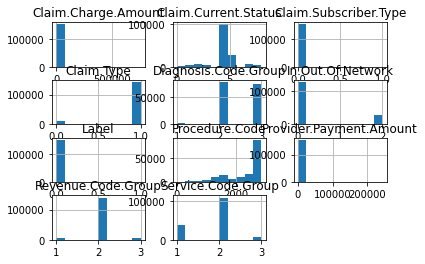

In [32]:
df_data.hist()
plt.show()

,Procedure.Code,Claim.Charge.Amount,In.Out.Of.Network,Provider.Payment.Amount,Claim.Type,Claim.Subscriber.Type,Claim.Current.Status,Revenue.Code.Group,Service.Code.Group,Diagnosis.Code.Group,Label
Procedure.Code,1.000000,0.061363,-0.076341,-0.021319,-0.042355,0.017320,-0.031836,-0.047573,-0.104328,0.052511,0.021403
Claim.Charge.Amount,0.061363,1.000000,-0.001729,0.183466,0.013692,-0.004526,0.025030,-0.023234,0.064896,0.006554,0.051487
In.Out.Of.Network,-0.076341,-0.001729,1.000000,-0.044094,0.134651,0.056018,0.316783,0.063518,0.254219,0.030959,-0.050948
Provider.Payment.Amount,-0.021319,0.183466,-0.044094,1.000000,-0.164183,-0.002738,-0.074138,0.008158,-0.005593,0.020371,-0.007765
Claim.Type,-0.042355,0.013692,0.134651,-0.164183,1.000000,0.008701,0.438851,-0.158159,-0.025311,0.028817,0.033571
Claim.Subscriber.Type,0.017320,-0.004526,0.056018,-0.002738,0.008701,1.000000,0.036612,0.098752,0.052609,-0.002259,0.035824
Claim.Current.Status,-0.031836,0.025030,0.316783,-0.074138,0.438851,0.036612,1.000000,-0.052801,0.068333,0.017864,0.009421
Revenue.Code.Group,-0.047573,-0.023234,0.063518,0.008158,-0.158159,0.098752,-0.052801,1.000000,0.158990,-0.000911,-0.217686
Service.Code.Group,-0.104328,0.064896,0.254219,-0.005593,-0.025311,0.052609,0.068333,0.158990,1.000000,0.000071,-0.080565
Diagnosis.Code.Group,0.052511,0.006554,0.030959,0.020371,0.028817,-0.002259,0.017864,-0.000911,0.000071,1.000000,-0.156067


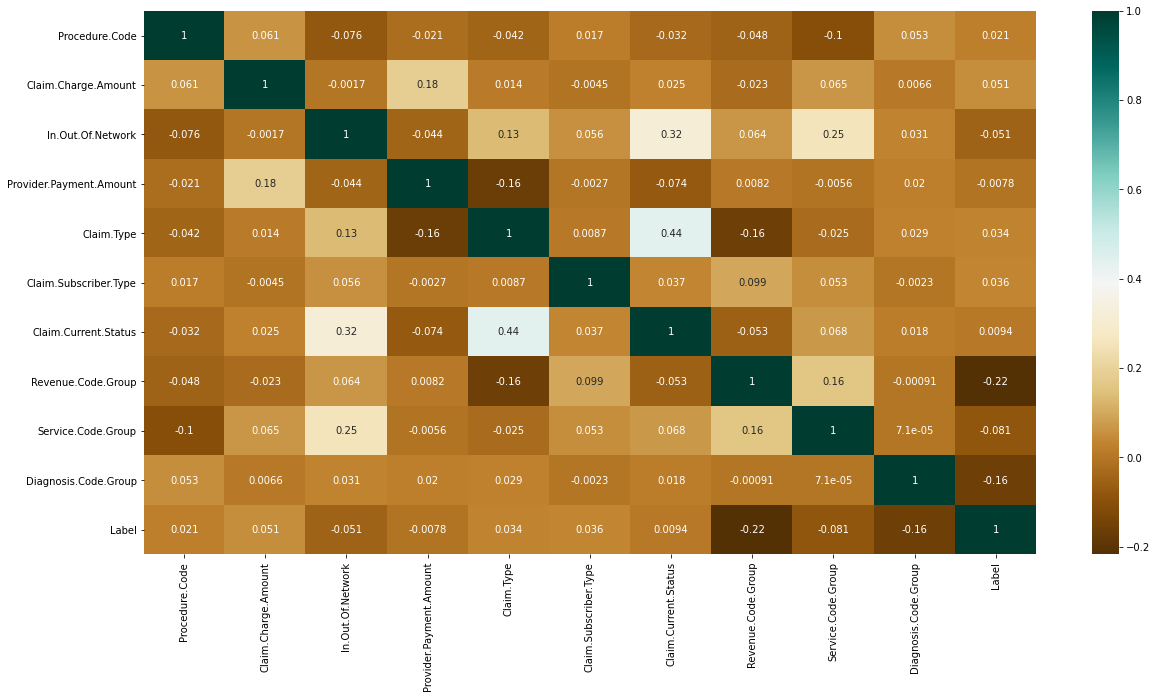

In [0]:
# TO Do -> Move up
categorical_columns = ["Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group", "Claim.Current.Status", 'Label']
#categorical_columns = [ "Procedure.Code", "In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status", "Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group", "Label"]

for col in categorical_columns: 
    df_data[col] = df_data[col].astype('int')
    
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
data_corr = df_data.corr()
sns.heatmap(data_corr, cmap="BrBG", annot=True)
data_corr

In [0]:
# Convert all the categorical columns type from object to category
#categorical_columns = ["Revenue.Code.Group", "Service.Code.Group", "Procedure.Code", "Provider.ID", "Diagnosis.Code.Group", "In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status", "Place.Of.Service.Code", "Denial.Reason.Code", 'Label']
categorical_columns = [ "Procedure.Code", "In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status", "Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group",  "Label"]

for col in categorical_columns: 
    df_data[col] = df_data[col].astype('category')

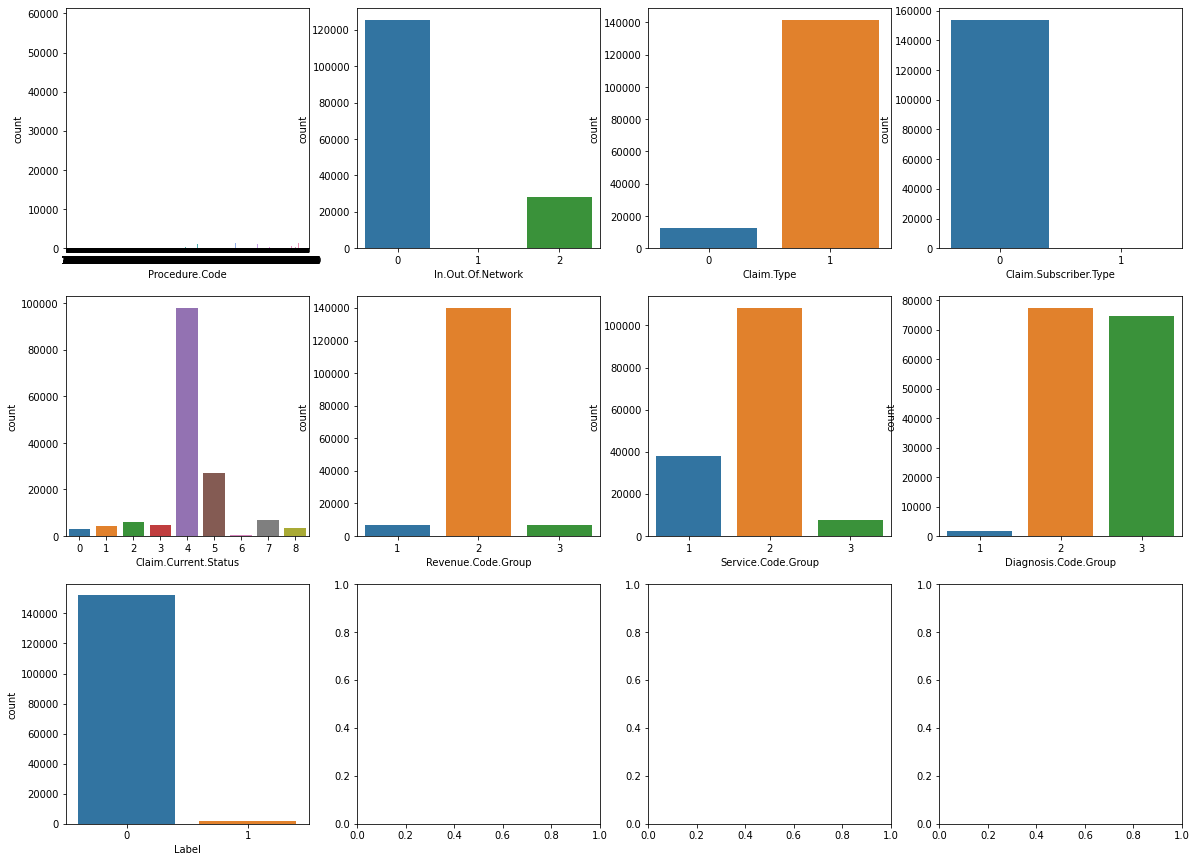

In [0]:
# Analyzing Categorical Variables

fig, ax = plt.subplots(3, 4, figsize=(20, 15))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    sns.countplot(df_data[variable], ax=subplot) 

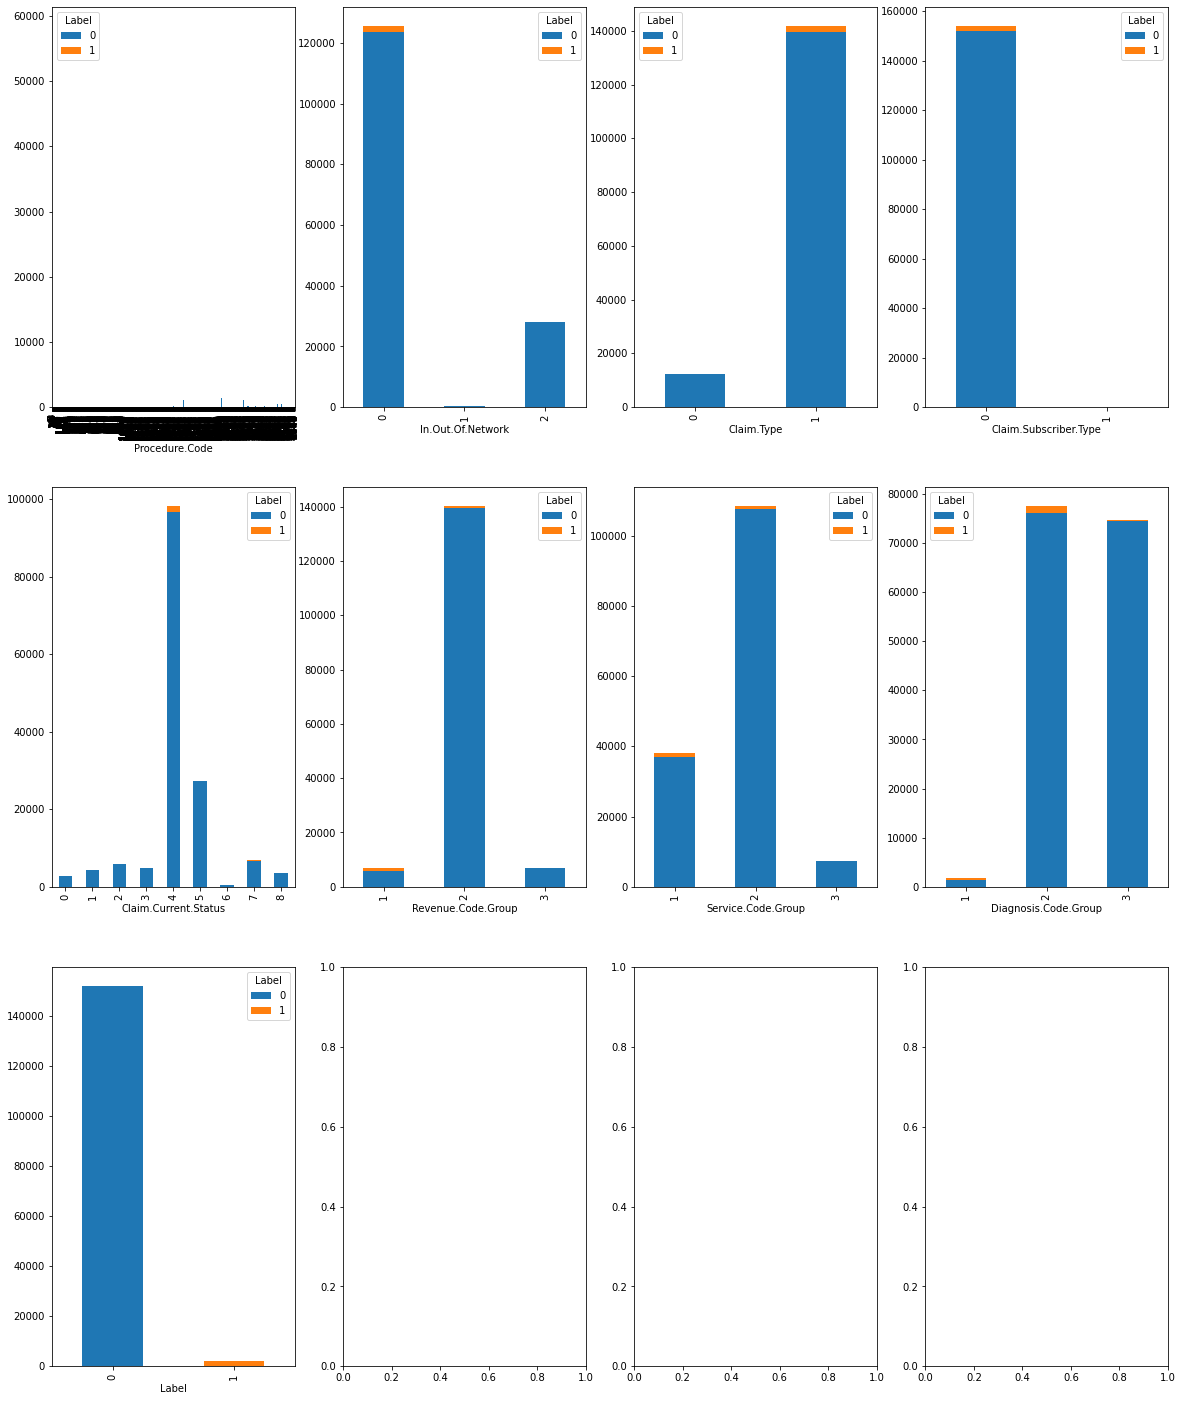

In [0]:
# Compare categorical variable with 'Label'
fig, ax = plt.subplots(3, 4, figsize=(20, 25))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    pd.crosstab(df_data[variable], df_data['Label']).plot(kind='bar', ax=subplot, stacked=True)

In [0]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153946 entries, 0 to 472558
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Procedure.Code           153946 non-null  category
 1   Claim.Charge.Amount      153946 non-null  float64 
 2   In.Out.Of.Network        153946 non-null  category
 3   Provider.Payment.Amount  153946 non-null  float64 
 4   Claim.Type               153946 non-null  category
 5   Claim.Subscriber.Type    153946 non-null  category
 6   Claim.Current.Status     153946 non-null  category
 7   Revenue.Code.Group       153946 non-null  category
 8   Service.Code.Group       153946 non-null  category
 9   Diagnosis.Code.Group     153946 non-null  category
 10  Label                    153946 non-null  category
dtypes: category(9), float64(2)
memory usage: 10.1 MB


In [0]:
numerical_columns = ["Claim.Charge.Amount", "Provider.Payment.Amount"]

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try stripplot
  warnings.warn(msg, UserWarning)


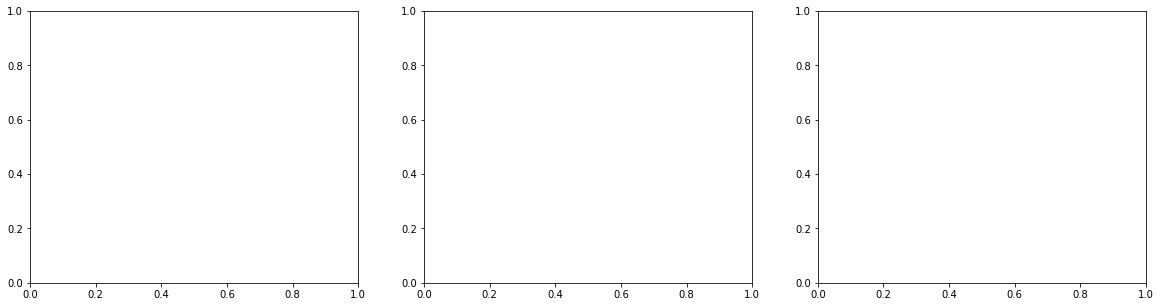

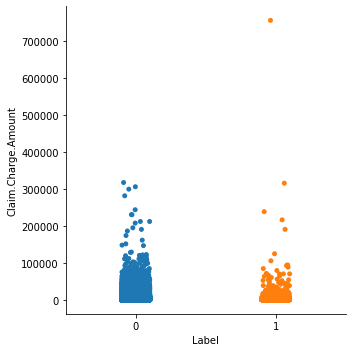

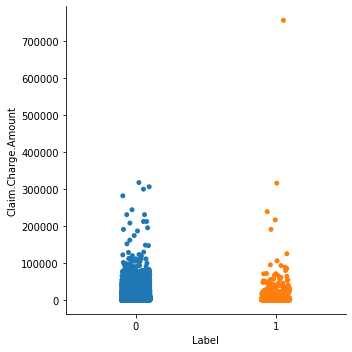

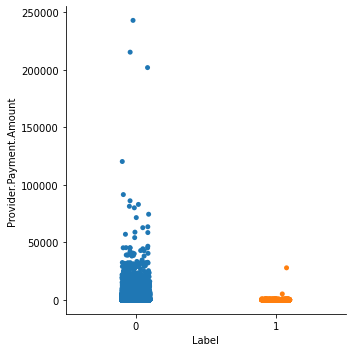

In [0]:
_,axes = plt.subplots(1, 3, figsize=(20, 5))
sns.catplot(x="Label", y=numerical_columns[0], data=df_data, ax=axes[0])
sns.catplot(x='Label', y='Claim.Charge.Amount', data=df_data)
sns.catplot(x='Label', y='Provider.Payment.Amount', data=df_data)


,Claim.Charge.Amount,Provider.Payment.Amount
Claim.Charge.Amount,1.000000,0.183466
Provider.Payment.Amount,0.183466,1.000000


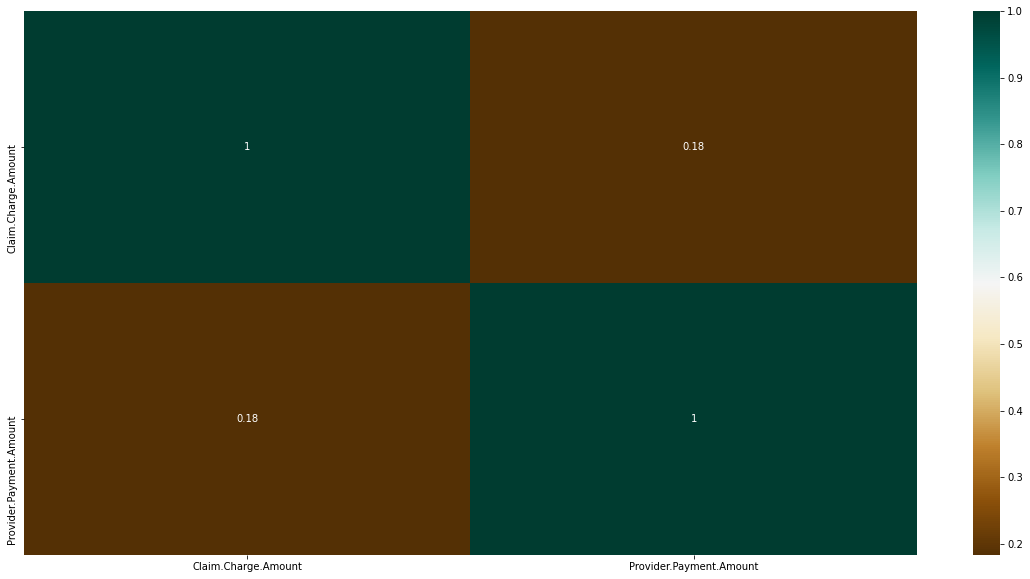

In [0]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
data_corr = df_data.corr()
sns.heatmap(data_corr, cmap="BrBG", annot=True)
data_corr

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3720: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try stripplot
  warnings.warn(msg, UserWarning)


AxesSubplot(0.125,0.125;0.227941x0.755)
AxesSubplot(0.398529,0.125;0.227941x0.755)


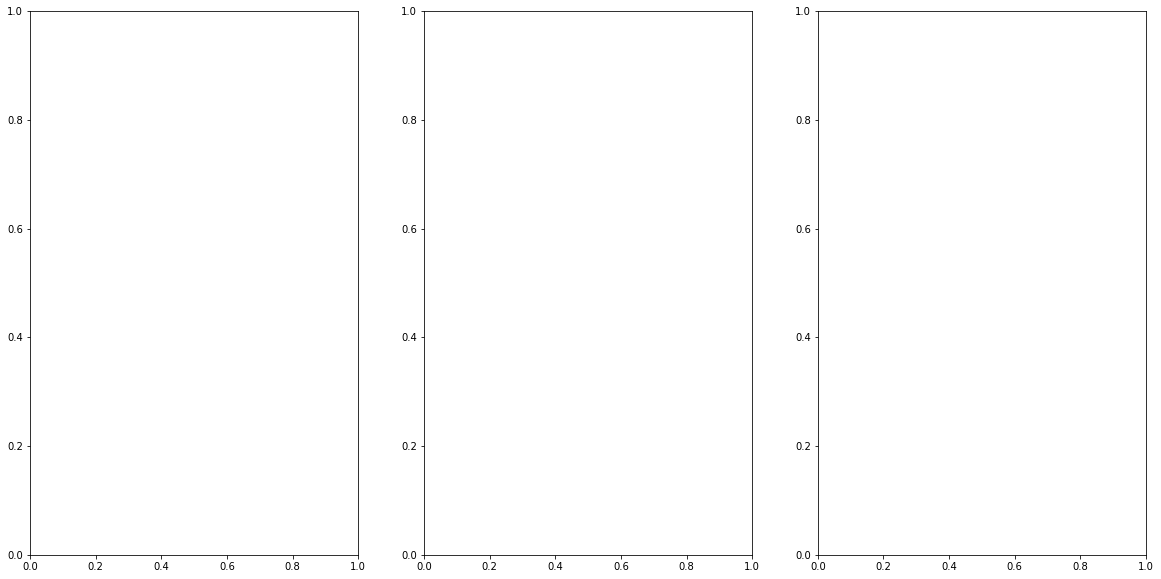

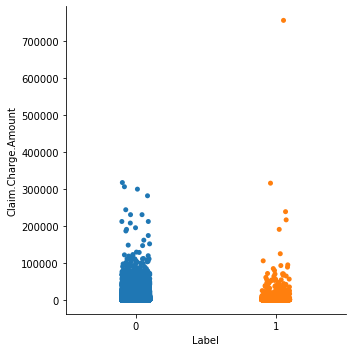

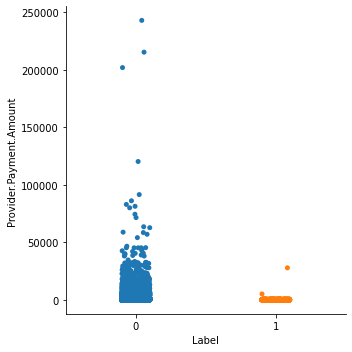

In [0]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    #sns.countplot(df_data[variable], ax=subplot) 
    sns.catplot(x="Label", y=variable, data=df_data, ax=subplot)
    print(subplot)

In [0]:
na_count = df_data["Provider.Payment.Amount"].sum()
print(na_count, df_data["Provider.Payment.Amount"].count())
print(df_data["Provider.Payment.Amount"][0])
print(df_data["Provider.Payment.Amount"].isin([0.0]).sum())

24417079.9497 153946
15036.21
140943


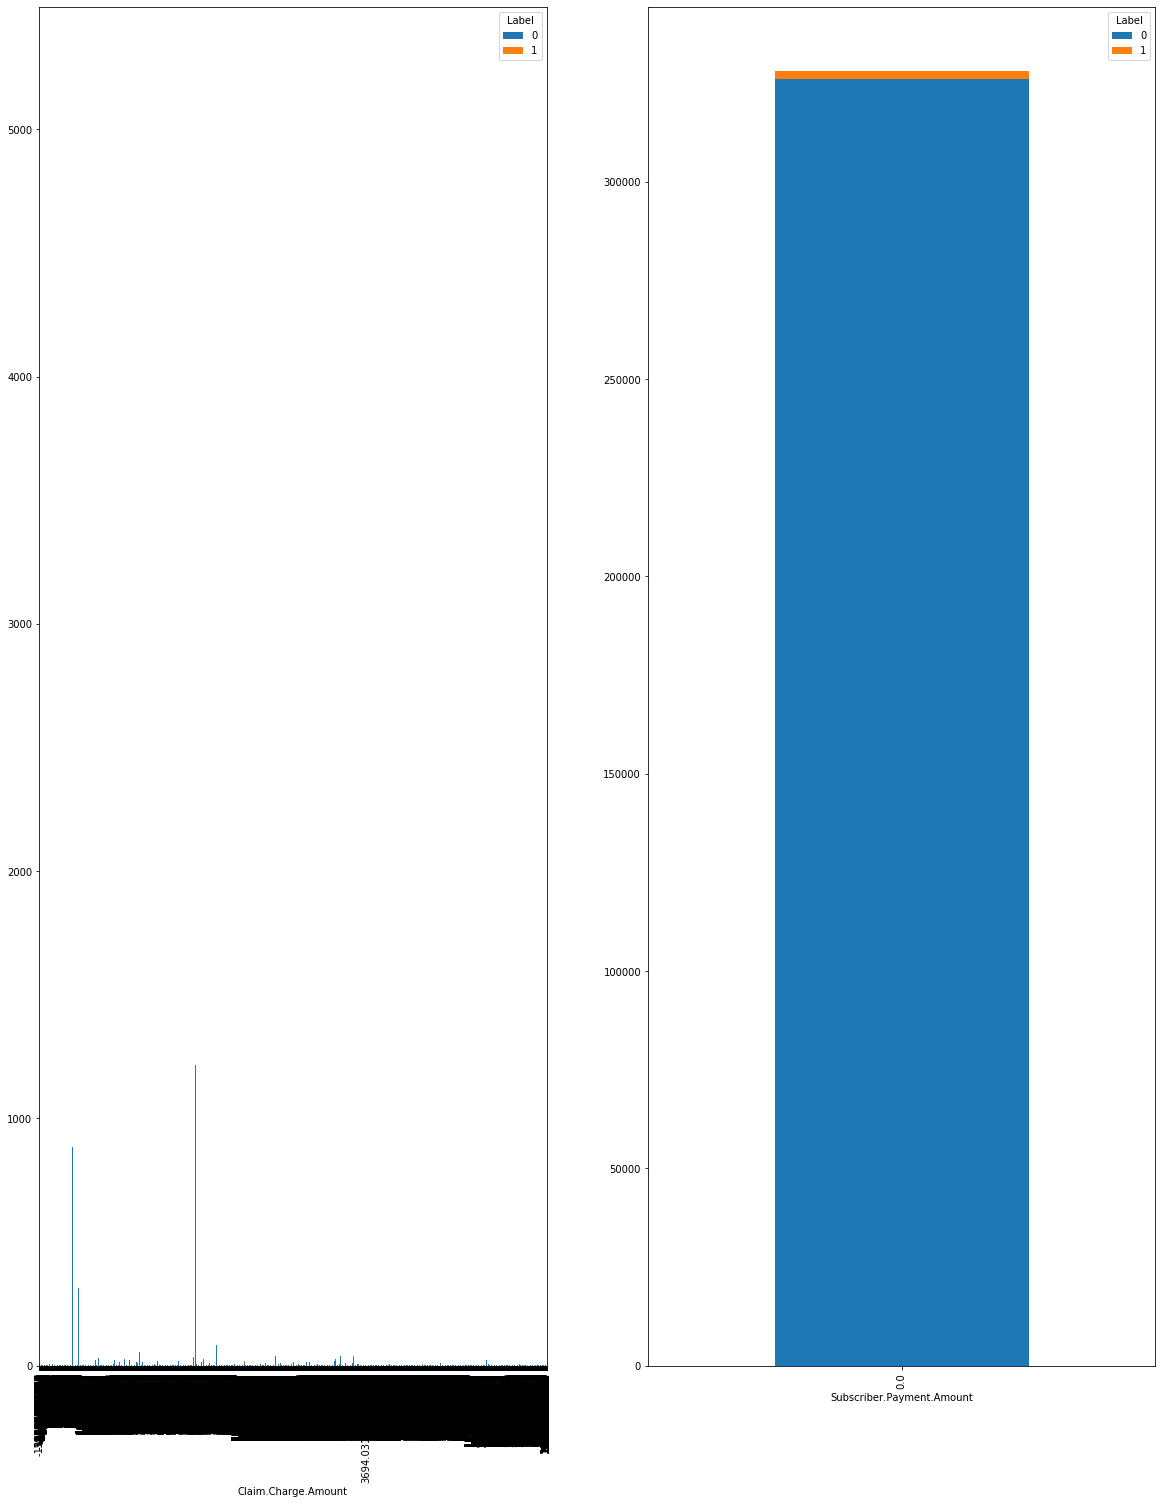

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(20, 25))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    pd.crosstab(df_data[variable], df_data['Label']).plot(kind='bar', ax=subplot, stacked=True)

In [0]:
df_data.corr()

,Claim.Charge.Amount,Provider.Payment.Amount
Claim.Charge.Amount,1.000000,0.183466
Provider.Payment.Amount,0.183466,1.000000


In [0]:
numerical_columns = ["Claim.Charge.Amount", "Provider.Payment.Amount"]

# 7 ID type. columns are useless from significance perspective:
# ["srlno", "Claim.Number", "Claim.Line.Number", "Member.ID", "Provider.ID", "Network.ID", "Agreement.ID" ]


df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153946 entries, 0 to 472558
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Procedure.Code           153946 non-null  category
 1   Claim.Charge.Amount      153946 non-null  float64 
 2   In.Out.Of.Network        153946 non-null  category
 3   Provider.Payment.Amount  153946 non-null  float64 
 4   Claim.Type               153946 non-null  category
 5   Claim.Subscriber.Type    153946 non-null  category
 6   Claim.Current.Status     153946 non-null  category
 7   Revenue.Code.Group       153946 non-null  category
 8   Service.Code.Group       153946 non-null  category
 9   Diagnosis.Code.Group     153946 non-null  category
 10  Label                    153946 non-null  category
dtypes: category(9), float64(2)
memory usage: 10.1 MB


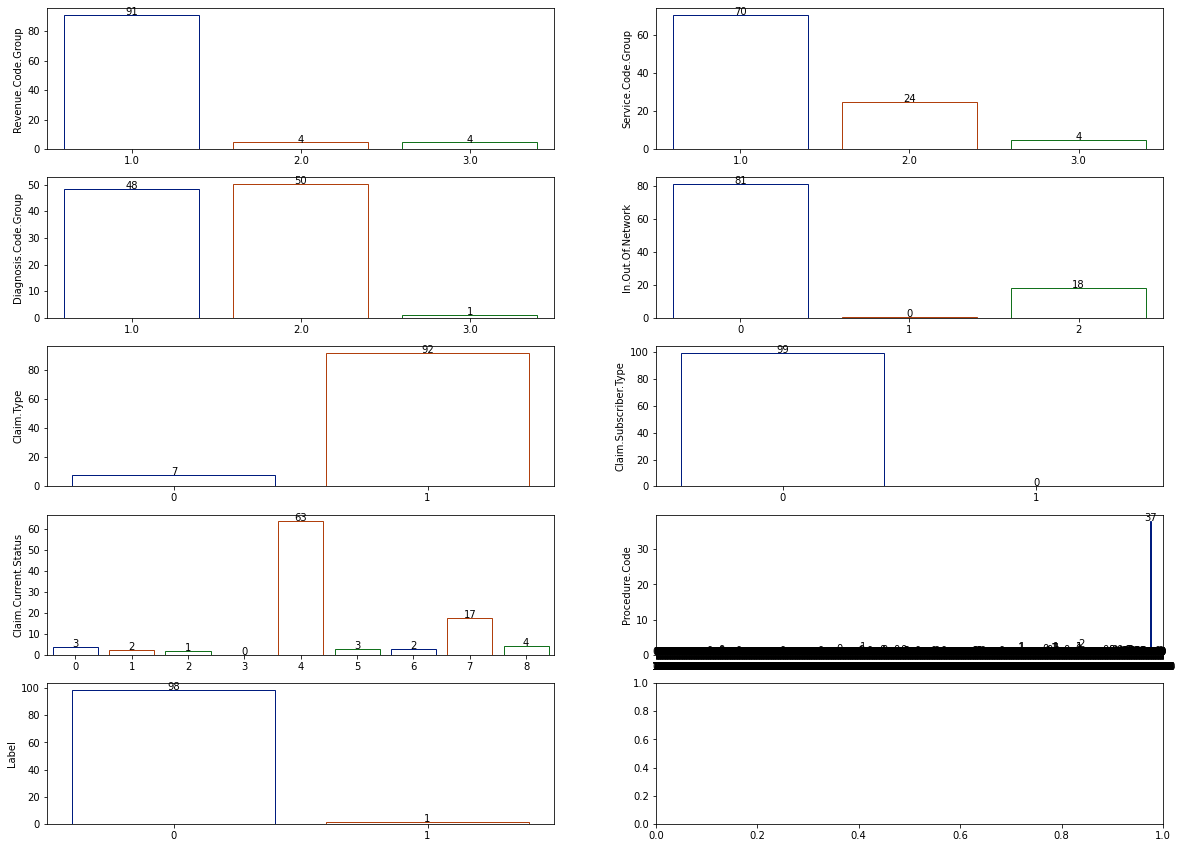

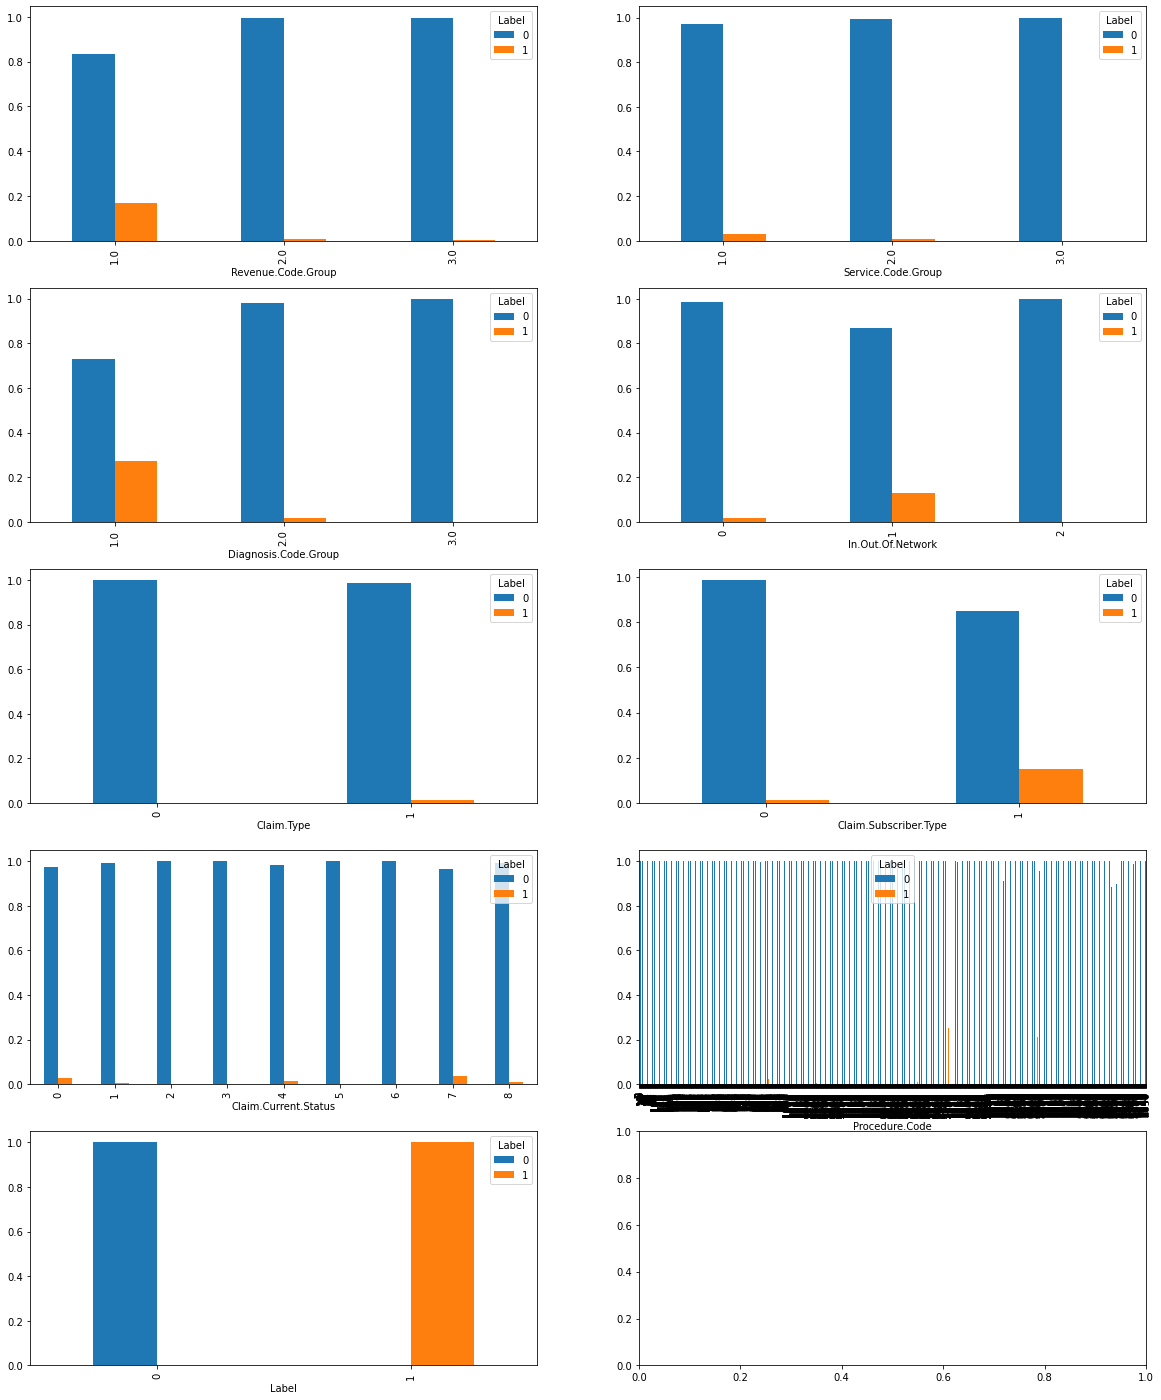

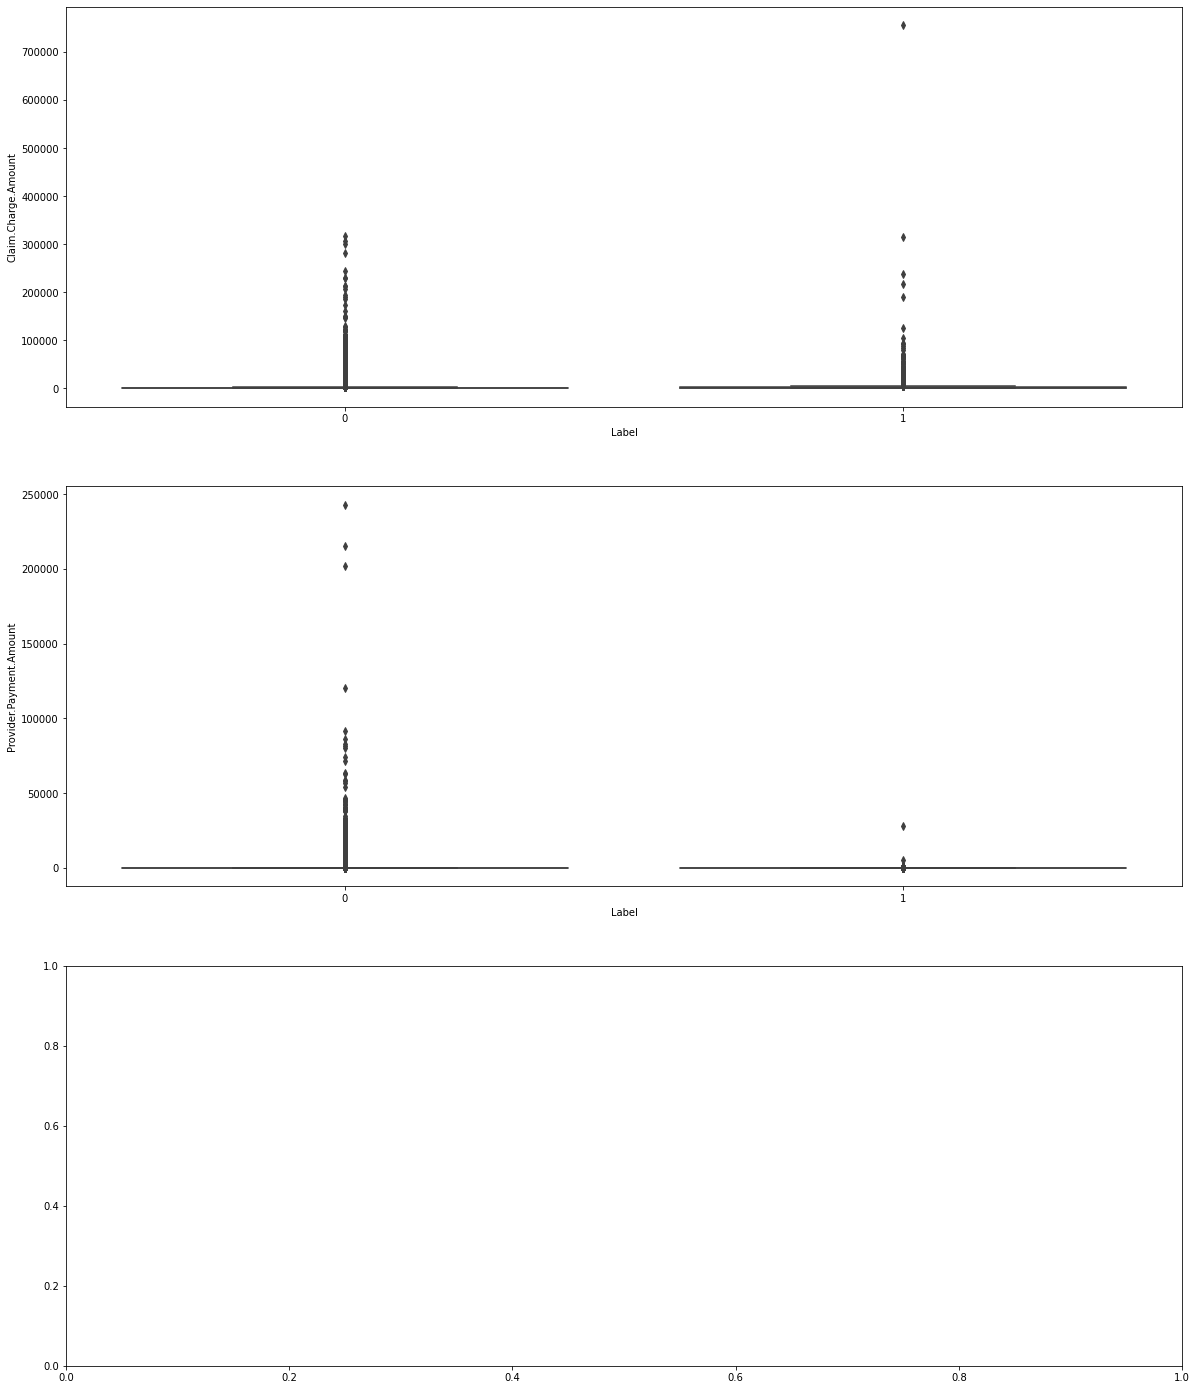

In [33]:
# Where to save the figures -  Incase this does not work you can comment this entire cell
#PROJECT_ROOT_DIR = "."
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(IMAGES_PATH, exist_ok=True)
IMAGES_PATH='/content/gdrive/My Drive/capstone-project/output_data/'

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#print('Histogram of All Numeric Values')
#df_data.hist(bins=50,figsize=(20,20))
#save_fig("Histogram of All Numeric Values")



#  - Incase this does not work you can comment this entire cell
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



# Analyzing Categorical Variables
# Incase this does not work you can comment this entire cell

categorical_columns = ["Revenue.Code.Group", 
                       "Service.Code.Group", 
                       "Diagnosis.Code.Group",
                       "In.Out.Of.Network", 
                       "Claim.Type", 
                       "Claim.Subscriber.Type", 
                       "Claim.Current.Status", 
                       "Procedure.Code", 
                       "Label"]


fig, ax = plt.subplots(5, 2, figsize=(20, 15))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    #myplot = sns.countplot(df_data[variable], ax=subplot)
    myplot = sns.barplot(x=df_data[variable].unique(), y=100*df_data[variable].value_counts()/len(df_data[variable]),edgecolor=sns.color_palette("dark", 3),facecolor=(0, 0, 0, 0),ax=subplot)
    show_values_on_bars(myplot, "v", 0.5)

# Incase this does not work you can comment this entire cell

categorical_columns = ["Revenue.Code.Group", 
                       "Service.Code.Group", 
                       "Diagnosis.Code.Group",
                       "In.Out.Of.Network", 
                       "Claim.Type", 
                       "Claim.Subscriber.Type", 
                       "Claim.Current.Status", 
                       "Procedure.Code", 
                       "Label"]

                
# Compare categorical variable with 'Label'
fig, ax = plt.subplots(5, 2, figsize=(20, 25))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    myplot = pd.crosstab(df_data[variable], df_data['Label'],normalize='index').plot(kind='bar', ax=subplot, stacked=False)


# Incase this does not work you can comment this entire cell

numerical_columns = ['Claim.Charge.Amount', 'Provider.Payment.Amount']
fig, ax = plt.subplots(3, 1, figsize=(20, 25))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    myplot = sns.boxplot(x='Label', y=variable, data=df_data,ax=subplot)


FROM HERE RUNNING Classifiers

In [0]:
y = df_data['Label']  
X = df_data.drop(["Label"], axis = 1)

In [0]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 88)

std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(Xtrain)
X_test_scaled = std_scale.transform(Xtest)
X_train_scaled = Xtrain
X_test_scaled = Xtest

In [0]:
# Running Decision Tree without SMOTE without ROS

In [0]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(X_train_scaled, ytrain)
y_pred = model.predict(X_test_scaled)

In [0]:
# Printing Tree

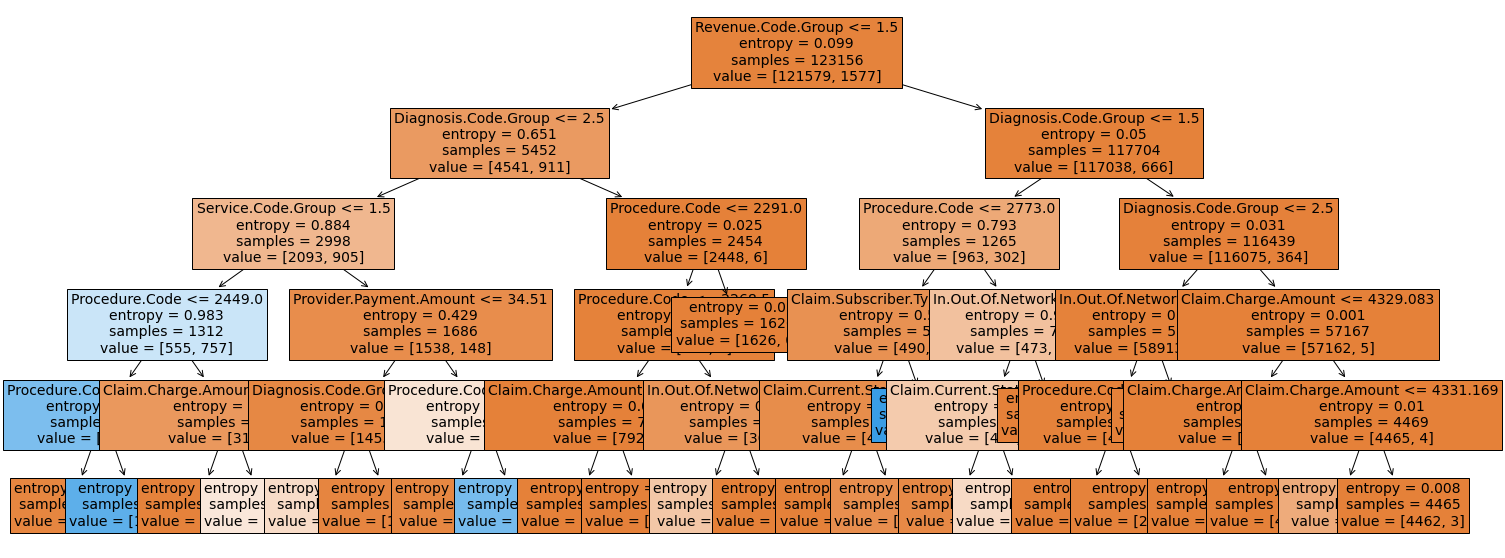

In [37]:
plt.figure(figsize=(25,10))
a = plot_tree(model, filled=True, feature_names=X.columns,  fontsize=14)

In [0]:
# Printing AUC and other Metrics

Predicted      0    1    All
Actual                      
0          30363   33  30396
1            196  198    394
All        30559  231  30790
Classification Report
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     30396
           1       0.86      0.50      0.63       394

    accuracy                           0.99     30790
   macro avg       0.93      0.75      0.81     30790
weighted avg       0.99      0.99      0.99     30790

Model Accuracy: 0.9925625202987983
0.9572087530886713


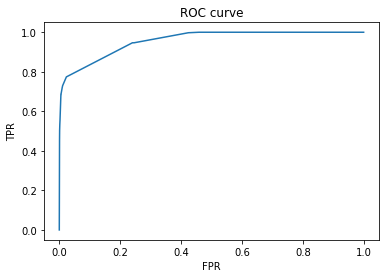

In [38]:
cm = confusion_matrix(ytest,y_pred)
print (pd.crosstab(ytest, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
print('Classification Report\n',classification_report(ytest,y_pred))
  
print ('Model Accuracy:',accuracy_score(ytest,y_pred))

predictions = model.predict_proba(Xtest)

print(roc_auc_score(ytest, predictions[:,1]))

fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [0]:
# Running Random Forest without SMOTE without ROS

In [39]:
paramgrid={'max_depth': [3, None],'n_estimators': (5,10),'max_features': (5,10)}
gs = GridSearchCV(estimator=RandomForestClassifier(),iid = True, param_grid = paramgrid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
classifier = gs.fit(Xtrain,ytrain)
y_pred = classifier.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [0]:
# Printing Tree

In [0]:
# Printing AUC and other Metrics

precision, recall, F-measure and support =  (0.9945948036402844, 0.994835985709646, 0.9946742093561348, None)
Accuracy: 0.994835985709646
Precision: 0.8386167146974063
Recall: 0.7385786802030457
f1_score =  0.785425101214575
Confusion Matrix [[30340    56]
 [  103   291]]
Classification report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     30396
           1       0.84      0.74      0.79       394

    accuracy                           0.99     30790
   macro avg       0.92      0.87      0.89     30790
weighted avg       0.99      0.99      0.99     30790

0.9572087530886713


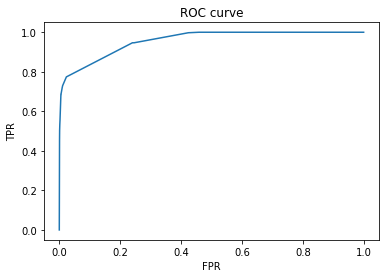

In [40]:
print('precision, recall, F-measure and support = ', precision_recall_fscore_support(ytest, y_pred, average='weighted'))
print("Accuracy:",accuracy_score(ytest, y_pred))
print("Precision:",precision_score(ytest, y_pred))
print("Recall:",recall_score(ytest, y_pred))
print('f1_score = ',f1_score(ytest, y_pred))
print('Confusion Matrix',confusion_matrix(ytest, y_pred))
print('Classification report: \n\n', classification_report(ytest, y_pred))

predictions = model.predict_proba(Xtest)

print(roc_auc_score(ytest, predictions[:,1]))

fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [0]:
# Running Decision Tree with Random Over Sample

In [41]:
ros = RandomOverSampler(random_state=88)
X_resampled_1, y_resampled_1 = ros.fit_sample(X, y)

yvals, counts = np.unique(ytest, return_counts=True)

yvals_ros, counts_ros = np.unique(y_resampled_1, return_counts=True)

print('Classes in test set:',dict(zip(yvals, counts)),'\n',
      'Classes in rebalanced train set:',dict(zip(yvals_ros, counts_ros)))

Xtrain, Xtest, ytrain, ytest = train_test_split(X_resampled_1, y_resampled_1, test_size=0.2,random_state = 88)
X_train_scaled = Xtrain
X_test_scaled = Xtest

Classes in test set: {0: 30396, 1: 394} 
 Classes in rebalanced train set: {0: 151975, 1: 151975}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
trained = model.fit(Xtrain, ytrain)
y_pred = model.predict(Xtest)


In [0]:
# Printing Tree

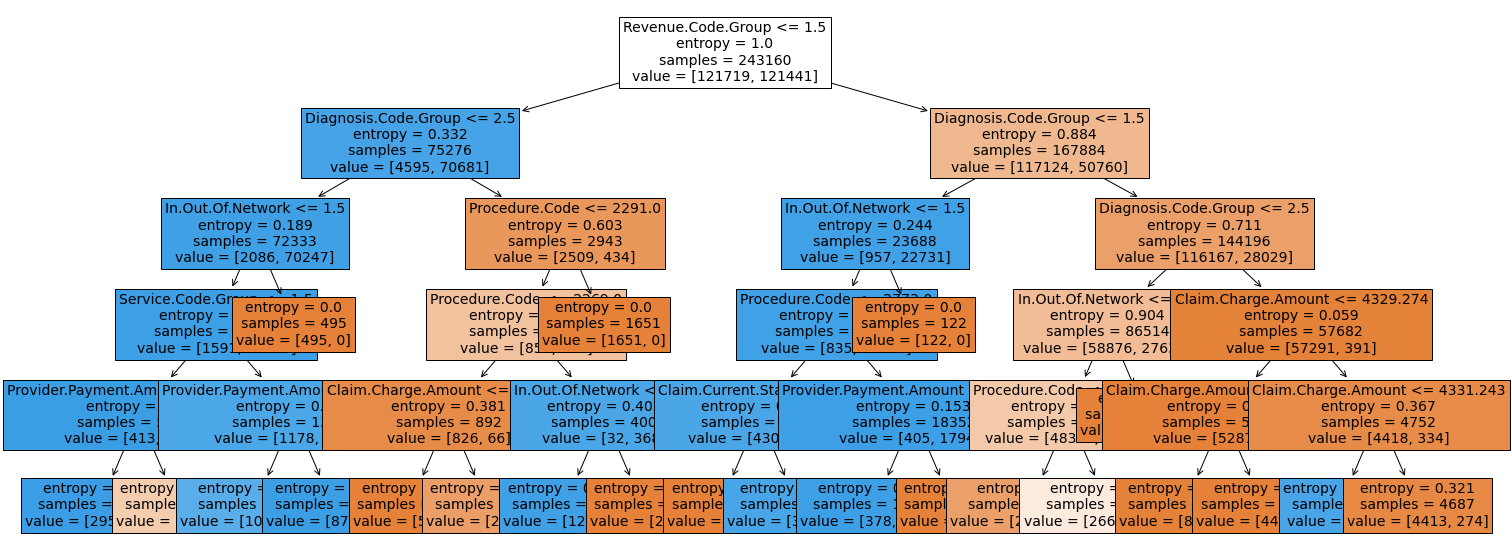

In [43]:
plt.figure(figsize=(25,10))
a = plot_tree(model, filled=True, feature_names=X.columns,  fontsize=14)

In [0]:
# Printing AUC and other metrics

Predicted      0      1    All
Actual                        
0          29654    602  30256
1           7093  23441  30534
All        36747  24043  60790
Classification Report
               precision    recall  f1-score   support

           0       0.81      0.98      0.89     30256
           1       0.97      0.77      0.86     30534

    accuracy                           0.87     60790
   macro avg       0.89      0.87      0.87     60790
weighted avg       0.89      0.87      0.87     60790

Model Accuracy: 0.8734166803750617
0.95690057254967


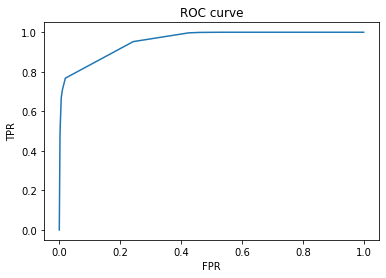

In [44]:
cm = confusion_matrix(ytest,y_pred)
print (pd.crosstab(ytest, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
from sklearn.metrics import classification_report
print('Classification Report\n',classification_report(ytest,y_pred))
    
from sklearn.metrics import accuracy_score
print ('Model Accuracy:',accuracy_score(ytest,y_pred))

predictions = model.predict_proba(Xtest)

print(roc_auc_score(ytest, predictions[:,1]))

fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [0]:
#Running Random Forest without SMOTE with ROS

In [45]:
paramgrid={'max_depth': [3, None],'n_estimators': (5,10),'max_features': (5,10)}
gs = GridSearchCV(estimator=RandomForestClassifier(),iid = True, param_grid = paramgrid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
classifier = gs.fit(Xtrain,ytrain)
y_pred = classifier.predict(Xtest)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [0]:
# Printing Tree

In [0]:
# Printing AUC and other metrics

precision, recall, F-measure and support =  (0.9913439531620284, 0.9912814607665734, 0.9912809559033491, None)
Accuracy: 0.9912814607665734
Precision: 0.9858475289850379
Recall: 0.9969542149734721
f1_score =  0.9913697648668012
Confusion Matrix [[29819   437]
 [   93 30441]]
Classification report: 

               precision    recall  f1-score   support

           0       1.00      0.99      0.99     30256
           1       0.99      1.00      0.99     30534

    accuracy                           0.99     60790
   macro avg       0.99      0.99      0.99     60790
weighted avg       0.99      0.99      0.99     60790

0.95690057254967


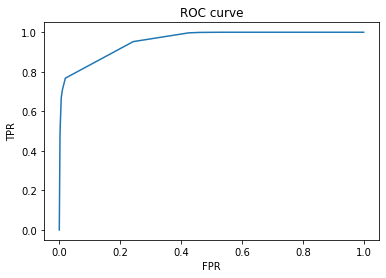

In [46]:
print('precision, recall, F-measure and support = ', precision_recall_fscore_support(ytest, y_pred, average='weighted'))
print("Accuracy:",accuracy_score(ytest, y_pred))
print("Precision:",precision_score(ytest, y_pred))
print("Recall:",recall_score(ytest, y_pred))
print('f1_score = ',f1_score(ytest, y_pred))
print('Confusion Matrix',confusion_matrix(ytest, y_pred))
print('Classification report: \n\n', classification_report(ytest, y_pred))

predictions = model.predict_proba(Xtest)

print(roc_auc_score(ytest, predictions[:,1]))

fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [47]:
# Running SMOTENC

X1 = X
X1.columns

Index(['Procedure.Code', 'Claim.Charge.Amount', 'In.Out.Of.Network',
       'Provider.Payment.Amount', 'Claim.Type', 'Claim.Subscriber.Type',
       'Claim.Current.Status', 'Revenue.Code.Group', 'Service.Code.Group',
       'Diagnosis.Code.Group'],
      dtype='object')

In [48]:
sm = SMOTENC(random_state=42, categorical_features=[0,2,4,5,6,7,8,9])
X_smot,y_smot = sm.fit_resample(X,y.ravel())
print('Original dataset samples per class {}'.format(Counter(y)))
print('Resampled dataset samples per class {}'.format(Counter(y_smot)))

Xtrain_smot, Xtest_smot, ytrain_smot, ytest_smot = train_test_split(X_smot, y_smot, test_size=0.2,random_state = 88)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset samples per class Counter({0: 151975, 1: 1971})
Resampled dataset samples per class Counter({0: 151975, 1: 151975})


In [0]:
# Running Decision Tree after performing SMOTE

In [0]:
model = DecisionTreeClassifier(criterion="entropy", max_depth=5)
model.fit(Xtrain_smot, ytrain_smot)
y_pred = model.predict(Xtest_smot)


In [0]:
# Printing Tree

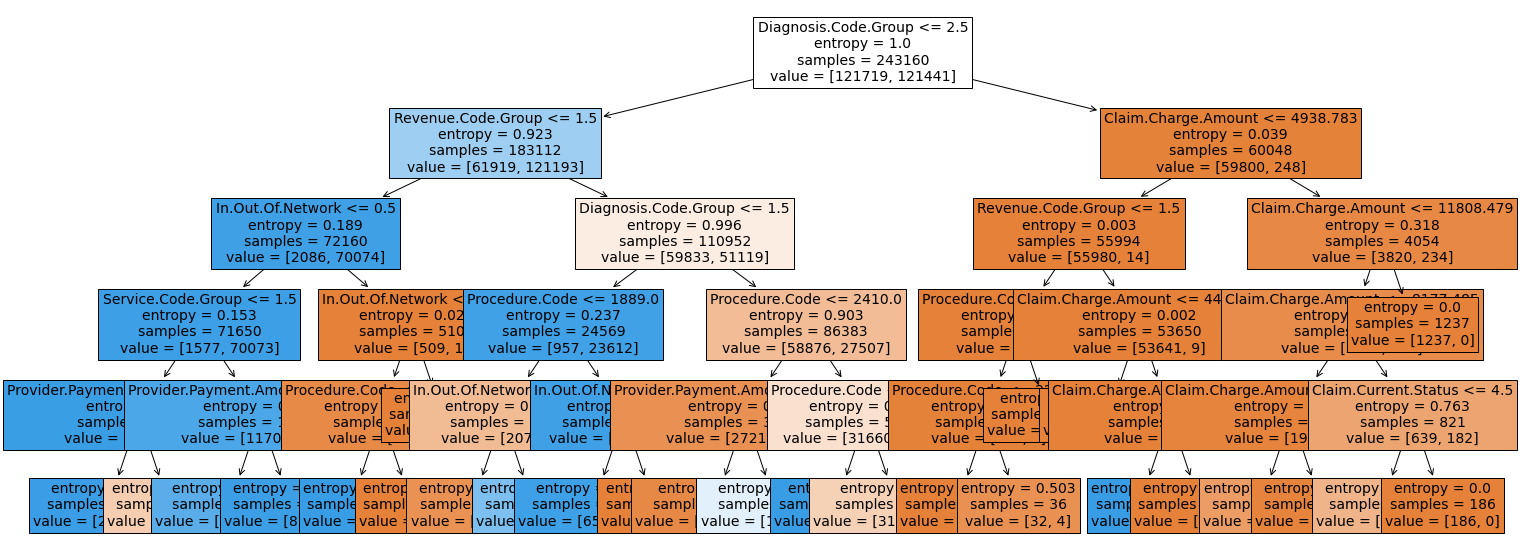

In [50]:
plt.figure(figsize=(25,10))
a = plot_tree(model, filled=True, feature_names=X.columns,  fontsize=14)

In [0]:
# Printing AUC and other metrics

Predicted      0      1    All
Actual                        
0          29263    993  30256
1           5554  24980  30534
All        34817  25973  60790
Classification Report
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     30256
           1       0.96      0.82      0.88     30534

    accuracy                           0.89     60790
   macro avg       0.90      0.89      0.89     60790
weighted avg       0.90      0.89      0.89     60790

Model Accuracy: 0.8923013653561441
0.95690057254967


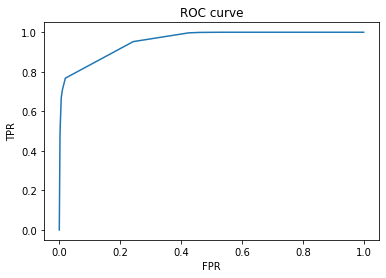

In [51]:
cm = confusion_matrix(ytest_smot,y_pred)
print (pd.crosstab(ytest, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
from sklearn.metrics import classification_report
print('Classification Report\n',classification_report(ytest_smot,y_pred))
    
from sklearn.metrics import accuracy_score
print ('Model Accuracy:',accuracy_score(ytest_smot,y_pred))

print(roc_auc_score(ytest, predictions[:,1]))
fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [0]:
# Running Random Forest after performing SMOTENC

In [52]:
paramgrid={'max_depth': [3, None],'n_estimators': (5,10),'max_features': (5,10)}
gs = GridSearchCV(estimator=RandomForestClassifier(),iid = True, param_grid = paramgrid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
classifier = gs.fit(Xtrain_smot,ytrain_smot)
y_pred = classifier.predict(Xtest_smot)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [0]:
# Printing Tree

Rerun Random Forest Classifier

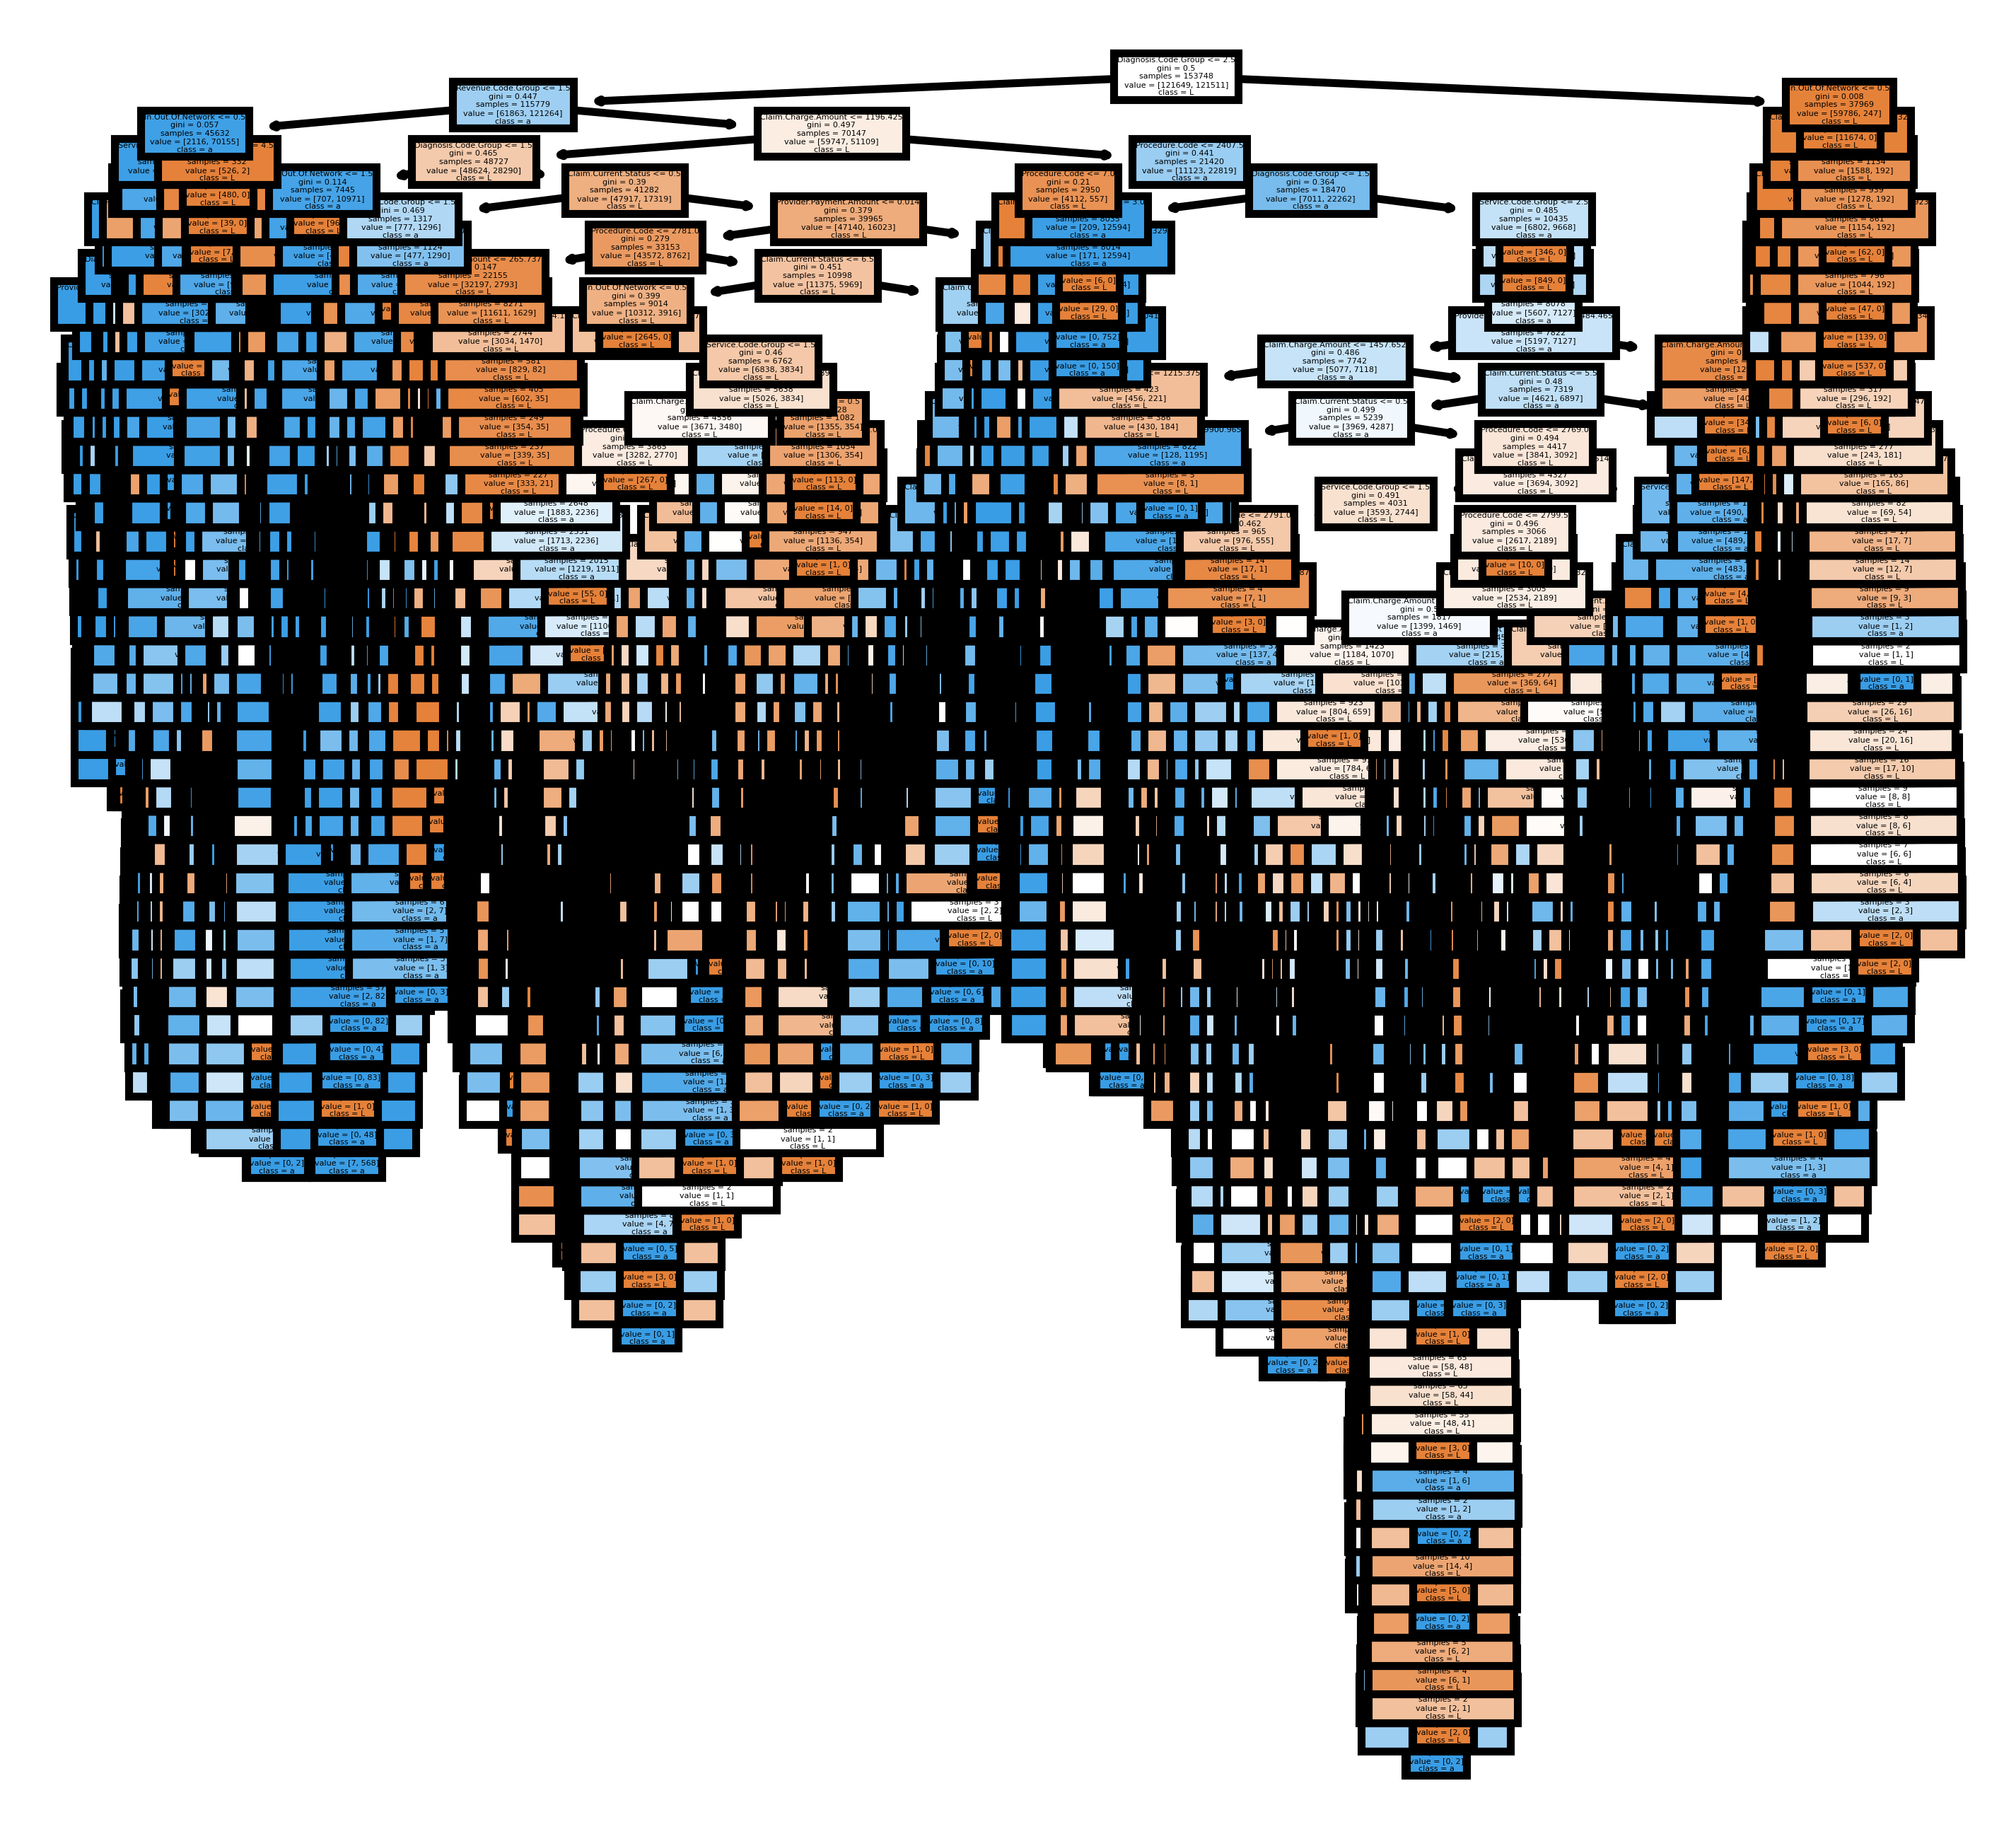

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
model = RandomForestClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=10,
                            random_state=0)
rf.fit(Xtrain_smot, ytrain_smot)

fn=X.columns
cn='Label'
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
 #   'Claim.Charge.Amount', 'In.Out.Of.Network', 'Subscriber.Payment.Amount','Provider.Payment.Amount', 'Claim.Type', 'Claim.Subscriber.Type', 'Claim.Current.Status', 'Revenue.Code.Group', 'Service.Code.Group', 'Diagnosis.Code.Group'

In [0]:
# Printing AUC and other metrics

precision, recall, F-measure and support =  (0.9715256190634868, 0.9715249218621483, 0.9715249841621009, None)
Accuracy: 0.9715249218621483
Precision: 0.9721648470541949
Recall: 0.9711141678129298
f1_score =  0.9716392233964118
Confusion Matrix [[29407   849]
 [  882 29652]]
Classification report: 

               precision    recall  f1-score   support

           0       0.97      0.97      0.97     30256
           1       0.97      0.97      0.97     30534

    accuracy                           0.97     60790
   macro avg       0.97      0.97      0.97     60790
weighted avg       0.97      0.97      0.97     60790

0.9840672334880516


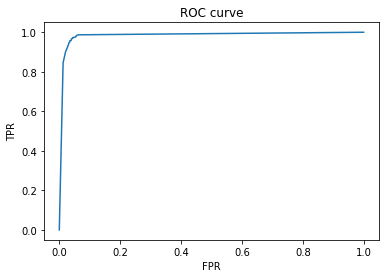

In [53]:
print('precision, recall, F-measure and support = ', precision_recall_fscore_support(ytest, y_pred, average='weighted'))
print("Accuracy:",accuracy_score(ytest_smot, y_pred))
print("Precision:",precision_score(ytest_smot, y_pred))
print("Recall:",recall_score(ytest_smot, y_pred))
print('f1_score = ',f1_score(ytest_smot, y_pred))
print('Confusion Matrix',confusion_matrix(ytest_smot, y_pred))
print('Classification report: \n\n', classification_report(ytest_smot, y_pred))

predictions = classifier.predict_proba(Xtest)

print(roc_auc_score(ytest, predictions[:,1]))

fpr, tpr, _ = roc_curve(ytest, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()